In [1]:
# -*- coding: utf-8 -*-
from copy import deepcopy
import random
import pickle
from scipy.signal import resample
import time
import sklearn
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE
from collections import Counter
from torchvision import datasets, transforms
from matplotlib.ticker import MultipleLocator

#超参数设置
batch_size = 16*4
d_model = 64
num_layers = 3
num_heads = 4
class_num = 4
d_inner = 512
dropout = 0.0
warm_steps = 4000
fea_num = 7
epoch = 20
PAD = 0
KS = 31
Fea_PLUS = 2
SIG_LEN = 256

In [8]:
#加载SVDB数据集并取出II导联
with open('./train_data_svdb.txt', "rb") as text4:
    Train_ecg_data = pickle.load(text4)
with open('./train_label_svdb.txt', "rb") as text5:
    Train_label = pickle.load(text5)
with open('./train_RR_svdb.txt', "rb") as text6:
    RR_Train = pickle.load(text6)

print(Train_ecg_data.shape)
print(Train_label.shape)
print(RR_Train.shape)

#预训练数据集
ecg_signal = Train_ecg_data[:,0,:]
whole_data = np.concatenate((Train_label,RR_Train,ecg_signal),axis=1)

(184261, 2, 256)
(184261, 1)
(184261, 2)


In [2]:
#DS2
with open('./train_data.txt', "rb") as text1:
    Train_ecg_data = pickle.load(text1)
with open('./train_label.txt', "rb") as text2:
    Train_label = pickle.load(text2)
with open('./train_RR.txt', "rb") as text3:
    RR_Train = pickle.load(text3)

print(Train_ecg_data.shape)
print(Train_label.shape)
print(RR_Train.shape)

with open('./test_data.txt', "rb") as text4:
    Test_ecg_data = pickle.load(text4)
with open('./test_label.txt', "rb") as text5:
    Test_label = pickle.load(text5)
with open('./test_RR.txt', "rb") as text6:
    RR_Test = pickle.load(text6)

print(Test_ecg_data.shape)
print(Test_label.shape)
print(RR_Test.shape)

#训练集
ecg_signal = Train_ecg_data[:,0,:]
whole_data = np.concatenate((Train_label,RR_Train,ecg_signal),axis=1)

#测试集
ecg_sig = Test_ecg_data[:,0,:]
raw_test = np.concatenate((Test_label,RR_Test,ecg_sig),axis=1)

#读取原始测试数据进行鲁棒性评测
with open('./test_data_raw.txt', "rb") as text4:
    Test_ecg_data_raw = pickle.load(text4)
Test_ecg_data_raw = Test_ecg_data_raw[:,0,:]

(67388, 2, 256)
(67388, 1)
(67388, 2)
(49552, 2, 256)
(49552, 1)
(49552, 2)


In [16]:
# #Random分组数据
# with open('./train_data_r.txt', "rb") as text1:
#     Train_ecg_data = pickle.load(text1)
# with open('./train_label_r.txt', "rb") as text2:
#     Train_label = pickle.load(text2)
# with open('./train_RR_r.txt', "rb") as text3:
#     RR_Train = pickle.load(text3)

# print(Train_ecg_data.shape)
# print(Train_label.shape)
# print(RR_Train.shape)

# #训练集
# ecg_signal = Train_ecg_data[:,0,:]
# whole_data = np.concatenate((Train_label,RR_Train,ecg_signal),axis=1)

(100632, 2, 256)
(100632, 1)
(100632, 2)


In [3]:
#sublayer.py
class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k)
        self.w_ks = nn.Linear(d_model, n_head * d_k)
        self.w_vs = nn.Linear(d_model, n_head * d_v)
        nn.init.normal_(self.w_qs.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_k)))
        nn.init.normal_(self.w_ks.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_k)))
        nn.init.normal_(self.w_vs.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_v)))

        self.attention = SDPAttention(temperature=np.power(d_k, 0.5))
        self.layer_norm = nn.LayerNorm(d_model)

        self.fc = nn.Linear(n_head * d_v, d_model)
        nn.init.xavier_normal_(self.fc.weight)

        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head

        sz_b, len_q, _ = q.size()
        sz_b, len_k, _ = k.size()
        sz_b, len_v, _ = v.size()

        residual = q

        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        q = q.permute(2, 0, 1, 3).contiguous().view(-1, len_q, d_k)  # (n*b) x lq x dk
        k = k.permute(2, 0, 1, 3).contiguous().view(-1, len_k, d_k)  # (n*b) x lk x dk
        v = v.permute(2, 0, 1, 3).contiguous().view(-1, len_v, d_v)  # (n*b) x lv x dv

        mask = mask.repeat(n_head, 1, 1)  # (n*b) x .. x ..
        output, attn = self.attention(q, k, v, mask=mask)

        output = output.view(n_head, sz_b, len_q, d_v)
        output = output.permute(1, 2, 0, 3).contiguous().view(sz_b, len_q, -1)  # b x lq x (n*dv)

        output = self.dropout(self.fc(output))
        output = self.layer_norm(output + residual)

        return output, attn


class SDPAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)
        self.softmax = nn.Softmax(dim=2)
        self.BN = nn.BatchNorm1d(SIG_LEN)

    def forward(self, q, k, v, mask=None):
        attn = torch.bmm(q, k.transpose(1, 2))
        attn = attn / self.temperature

        if mask is not None:
            attn = attn.masked_fill(mask, -np.inf)

        attn = self.BN(attn)
        attn = self.softmax(attn)
        attn = self.dropout(attn)
        output = torch.bmm(attn, v)

        return output, attn

In [4]:
#block.py
class PositionwiseFeedForward(nn.Module):
    ''' A two-feed-forward-layer module '''

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Conv1d(d_in, d_hid, 1)  # position-wise
        self.w_2 = nn.Conv1d(d_hid, d_in, 1)  # position-wise
        self.layer_norm = nn.LayerNorm(d_in)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        output = x.transpose(1, 2)
        output = self.w_2(F.relu((self.w_1(output))))
        output = output.transpose(1, 2)
        output = self.dropout(output)
        output = self.layer_norm(output + residual)
        return output


def get_sinusoid_encoding_table(n_position, d_hid, padding_idx=None):
    ''' Sinusoid position encoding table '''

    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_hid)

    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_hid)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    if padding_idx is not None:
        # zero vector for padding dimension
        sinusoid_table[padding_idx] = 0.

    return torch.FloatTensor(sinusoid_table)


def get_non_pad_mask(seq):
    assert seq.dim() == 2
    return seq.ne(PAD).type(torch.float).unsqueeze(-1)


def get_subsequent_mask(seq):
    ''' For masking out the subsequent info. '''

    sz_b, len_s = seq.size()
    subsequent_mask = torch.triu(
        torch.ones((len_s, len_s), device=seq.device, dtype=torch.uint8), diagonal=1)
    subsequent_mask = subsequent_mask.unsqueeze(0).expand(sz_b, -1, -1)  # b x ls x ls

    return subsequent_mask


def get_attn_key_pad_mask(seq_k, seq_q):
    ''' For masking out the padding part of key sequence. '''

    # Expand to fit the shape of key query attention matrix.
    len_q = seq_q.size(1)
    padding_mask = seq_k.eq(PAD)
    padding_mask = padding_mask.unsqueeze(1).expand(-1, len_q, -1)  # b x lq x lk

    return padding_mask

class EncoderLayer(nn.Module):
    ''' Compose with two layers '''

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(
            n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(self, enc_input, non_pad_mask=None, slf_attn_mask=None):
        enc_output, enc_slf_attn = self.slf_attn(
            enc_input, enc_input, enc_input, mask=slf_attn_mask)
        enc_output *= non_pad_mask

        enc_output = self.pos_ffn(enc_output)
        enc_output *= non_pad_mask

        return enc_output, enc_slf_attn

In [5]:
#model.py
class Encoder(nn.Module):
    ''' A encoder model with self attention mechanism. '''

    def __init__(
            self,
            d_feature,
            n_layers, n_head, d_k, d_v,
            d_model, d_inner, dropout=0.1):
        super().__init__()

        n_position = d_feature + 1
        self.src_word_emb = nn.Conv1d(1, d_model, kernel_size=KS, padding=int((KS - 1) / 2))

        self.position_enc = nn.Embedding.from_pretrained(
            get_sinusoid_encoding_table(n_position, d_model, padding_idx=0),
            freeze=True)

        self.layer_stack = nn.ModuleList([
            EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])

    def forward(self, src_seq, src_pos):
        # -- Prepare masks
        non_pad_mask = get_non_pad_mask(src_seq)
        slf_attn_mask = get_attn_key_pad_mask(seq_k=src_seq, seq_q=src_seq)
        # -- Forward
        enc_output = src_seq.unsqueeze(1)
        enc_output = self.src_word_emb(enc_output)
        enc_output = enc_output.transpose(1, 2)
        enc_output.add_(self.position_enc(src_pos))

        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn = enc_layer(
                enc_output,
                non_pad_mask=non_pad_mask,
                slf_attn_mask=slf_attn_mask)
        return enc_output,


class Transformer(nn.Module):
    ''' A sequence to sequence model with attention mechanism. '''
    def __init__(
            self, device,
            d_feature, d_model=512, d_inner=2048,
            n_layers=6, n_head=8, d_k=64, d_v=64, dropout=0.1,
            class_num=5):

        super().__init__()

        self.encoder = Encoder(d_feature, n_layers, n_head, d_k, d_v, d_model, d_inner, dropout)
        self.device = device

        self.linear1_cov = nn.Conv1d(d_feature, 1, kernel_size=1)
        self.linear1_linear = nn.Linear(d_model+Fea_PLUS, class_num)#64+2=>4
#         # try different linear style(未连接手工特征)
#         self.linear2_cov = nn.Conv1d(d_model, 1, kernel_size=1)
#         self.linear2_linear = nn.Linear(d_feature, class_num)

    def forward(self, src_seq, fea_plus):
        b, l = src_seq.size()
        src_pos = torch.LongTensor(
            [list(range(1, l + 1)) for i in range(b)]
        )
        src_pos = src_pos.to(self.device)

        enc_output, *_ = self.encoder(src_seq, src_pos)
        dec_output = enc_output
        res = self.linear1_cov(dec_output)
        res = res.contiguous().view(res.size()[0], -1)
        res = torch.cat((res,fea_plus),1)
        res = self.linear1_linear(res)
        return res

In [6]:
#optim.py
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [7]:
#dataset.py
class SignalDataset(Dataset):
    def __init__(self, raw_data):
        for i in range(raw_data[:,3:].shape[0]):
            if random.random() > 0.5:#0.5为阈值，以一定几率随机增强数据
                raw_data[i,3:] = raw_data[i,3:] * 0.1*np.random.randint(8,13)
                raw_data[i,3:] = raw_data[i,3:] + 0.01*np.random.randint(15,40)*np.sin(np.pi/np.random.randint(40,90)*np.arange(SIG_LEN)+np.pi*np.random.randint(0,10)/10)
                raw_data[i,3:] = raw_data[i,3:] + np.random.normal(0,0.01*np.random.randint(0,10),SIG_LEN)
                raw_data[i,3:] = raw_data[i,3:] + 0.02*np.random.randint(-20,21)
        print("添加噪声")
        self._signal = torch.FloatTensor(raw_data[:, 3:])
        self._fea_plus = torch.FloatTensor(raw_data[:, 1:3])
        self._label = torch.LongTensor(raw_data[:, 0])
        # self._emd = torch.FloatTensor(emd_data)


    @property
    def n_insts(self):
        ''' Property for dataset size '''
        return len(self._label)

    @property
    def sig_len(self):
        return self._signal.shape[1]

    def __len__(self):
        return self.n_insts

    def __getitem__(self, idx):
        return self._signal[idx], self._fea_plus[idx], self._label[idx]
    
class SignalDataset_o(Dataset):
    def __init__(self, raw_data):

        print("未添加噪声")
        self._signal = torch.FloatTensor(raw_data[:, 3:])
        self._fea_plus = torch.FloatTensor(raw_data[:, 1:3])
        self._label = torch.LongTensor(raw_data[:, 0])
        # self._emd = torch.FloatTensor(emd_data)


    @property
    def n_insts(self):
        ''' Property for dataset size '''
        return len(self._label)

    @property
    def sig_len(self):
        return self._signal.shape[1]

    def __len__(self):
        return self.n_insts

    def __getitem__(self, idx):
        return self._signal[idx], self._fea_plus[idx], self._label[idx]

In [8]:
#FocalLoss.py
class FocalLoss(nn.Module):
    def __init__(self, class_num, alpha=None, gamma=2, average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.average = average

        if alpha is None:
            self.alpha = torch.ones(class_num, 1)
        else:
            if isinstance(alpha, torch.Tensor):#將alpha轉換爲Tensor
                self.alpha = alpha
            else:
                self.alpha = torch.Tensor(alpha)

    def forward(self, inputs, targets, device):
        N, C = inputs.size()#分別爲預測值的行和列數
        P = F.softmax(inputs, dim=1)

        class_mask = inputs.new_zeros(N, C)
        ids = targets.view(-1, 1)#將標籤轉化爲X行1列
        class_mask.scatter_(1, ids, 1.)#將targets轉換爲onehot形式
        if inputs.is_cuda and not self.alpha.is_cuda:
            self.alpha = self.alpha.to(device)
        alpha = self.alpha[ids.view(-1)]

        probs = (P * class_mask).sum(1).view(-1, 1)

        log_p = probs.log()

        batch_loss = -alpha * torch.pow((1 - probs),self.gamma) * log_p

        if self.average:
            loss = batch_loss.mean()
        else:
            loss = batch_loss.sum()
        return loss

In [9]:
#roc.py
import sys
import math
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 2

def plot_roc(all_labels, all_pred):
    enc = OneHotEncoder()
    all_labels = np.array(all_labels)
    all_labels = all_labels[:,np.newaxis]
    label_h =enc.fit_transform(all_labels)
    label_h = label_h.toarray()
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(class_num):
        fpr[i], tpr[i], _ = roc_curve(label_h[:, i], all_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(class_num)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(class_num):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= class_num
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    fpr["micro"], tpr["micro"], _ = roc_curve(label_h.ravel(), all_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    lw=2
    fig, ax = plt.subplots(figsize=(6.5,6))
#     plt.figure(figsize=(8, 6))
    yminorLocator = MultipleLocator(0.1)  # 将此y轴次刻度标签设置为0.1的倍数
    xminorLocator = MultipleLocator(0.1)
    ax.yaxis.set_minor_locator(yminorLocator)
    ax.xaxis.set_minor_locator(xminorLocator)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro roc (AUC = {0:0.3f})'
                   ''.format(roc_auc["micro"]),
             color='steelblue', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro roc (AUC = {0:0.3f})'
                   ''.format(roc_auc["macro"]),
             color='peru', linestyle=':', linewidth=4)

    colors = cycle(['pink', 'lime', 'skyblue', 'cyan'])
    c = ['normal','sveb','veb','fusion']
    for i, color in zip(range(class_num), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='roc of {0} (AUC = {1:0.3f})'
                 ''.format(c[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.01, 1.0])
    plt.ylim([-0.01, 1.01])
    plt.grid(which='both', color='gray', ls='--')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC curve')
    plt.legend(loc="lower right", fontsize=18)
#     plt.savefig("DS2_pre.jpg", dpi=500)
    plt.show()

[ Epoch 0 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.32978, accuracy: 88.555 %, elapse: 0.791 min
[41114.  6754.  4315.  1727.]


[[9491   43   85   18]
 [ 162 1927   17    0]
 [  55   37 1211   14]
 [ 100    7   23  288]]
acc_SP is : 0.9335149863760218
pre_i is : [0.9676794453507341, 0.9568023833167825, 0.906437125748503, 0.9]
rec_i is : [0.9848500570717028, 0.9150047483380817, 0.9195140470766895, 0.6889952153110048]
F1_i is : [0.9761892517356647, 0.9354368932038835, 0.9129287598944591, 0.7804878048780489]
  - (Validation)  loss:  0.12659, accuracy: 95.838 %, elapse: 0.071 min
[9808. 2014. 1336.  320.]


[[40114   579   938   169]
 [  593  1516   222     6]
 [  612   163  3914   115]
 [  148     3    54   406]]
acc_SP is : 0.721830550401979
pre_i is : [0.9673716449224685, 0.670499778858912, 0.7632605304212169, 0.5833333333333334]
rec_i is : [0.9596650717703349, 0.6486949080017116, 0.8147377185678601, 0.6644844517184942]
F1_i is : [0.963502948346884, 0.6594171378860375, 0.7881594844945631, 0.6212700841622035]
  - (Testing)  loss:  0.22662, accuracy: 92.731 %, elapse: 0.258 min
[41467.  2261.  5128.   696.]
    - [Info] The checkpoint file has been updated.
[ Epoch 1 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.11107, accuracy: 96.279 %, elapse: 0.791 min
[38857.  8385.  5191.  1477.]


[[9503   53   46   35]
 [  36 2056   14    0]
 [  34   29 1243   11]
 [  83    0   23  312]]
acc_SP is : 0.9447933019361591
pre_i is : [0.9841549295774648, 0.961646398503274, 0.9374057315233786, 0.8715083798882681]
rec_i is : [0.98609525786033, 0.976258309591643, 0.9438116932422171, 0.7464114832535885]
F1_i is : [0.9851241382884984, 0.9688972667295004, 0.9405978055240258, 0.8041237113402061]
  - (Validation)  loss:  0.08234, accuracy: 97.299 %, elapse: 0.071 min
[9656. 2138. 1326.  358.]


[[40162   600   590   448]
 [  566  1521   245     5]
 [  414   146  4115   129]
 [  117     0    75   419]]
acc_SP is : 0.7301338478234656
pre_i is : [0.973411861654427, 0.6709307454786061, 0.8189054726368159, 0.41858141858141856]
rec_i is : [0.9608133971291866, 0.6508344030808729, 0.8565778517901749, 0.6857610474631751]
F1_i is : [0.9670715997062329, 0.6607298001737619, 0.837318140197375, 0.5198511166253101]
  - (Testing)  loss:  0.25098, accuracy: 93.270 %, elapse: 0.258 min
[41259.  2267.  5025.  1001.]
    - [Info] The checkpoint file has been updated.
[ Epoch 2 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.08634, accuracy: 97.166 %, elapse: 0.792 min
[38747.  8453.  5191.  1519.]


[[9551   31   36   19]
 [  32 2059   15    0]
 [  57   16 1239    5]
 [  80    2    8  328]]
acc_SP is : 0.9648749334752528
pre_i is : [0.9826131687242798, 0.9767552182163188, 0.9545454545454546, 0.9318181818181818]
rec_i is : [0.9910760610148387, 0.9776828110161444, 0.9407744874715261, 0.784688995215311]
F1_i is : [0.9868264710440667, 0.9772187944945421, 0.9476099426386233, 0.8519480519480519]
  - (Validation)  loss:  0.07071, accuracy: 97.767 %, elapse: 0.072 min
[9720. 2108. 1298.  352.]


[[40775   535   256   234]
 [  636  1507   190     4]
 [  647   113  3958    86]
 [  184     1    37   389]]
acc_SP is : 0.8008207934336525
pre_i is : [0.9652715307040386, 0.6989795918367347, 0.8912407115514523, 0.5455820476858345]
rec_i is : [0.9754784688995215, 0.6448438168592212, 0.8238967527060783, 0.6366612111292962]
F1_i is : [0.9703481592537064, 0.6708212775428445, 0.8562466197944836, 0.5876132930513595]
  - (Testing)  loss:  0.23547, accuracy: 94.101 %, elapse: 0.259 min
[42242.  2156.  4441.   713.]
    - [Info] The checkpoint file has been updated.
[ Epoch 3 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.08353, accuracy: 97.188 %, elapse: 0.792 min
[38740.  8437.  5197.  1536.]


[[9482   65   24   66]
 [  25 2076    5    0]
 [  40   20 1250    7]
 [  51    2   14  351]]
acc_SP is : 0.947680412371134
pre_i is : [0.987914148780996, 0.9597780859916782, 0.9667440061871616, 0.8278301886792453]
rec_i is : [0.9839161564802325, 0.9857549857549858, 0.9491268033409264, 0.8397129186602871]
F1_i is : [0.9859110995580972, 0.972593113141251, 0.9578544061302681, 0.8337292161520191]
  - (Validation)  loss:  0.07047, accuracy: 97.633 %, elapse: 0.071 min
[9598. 2163. 1293.  424.]


[[39208   839   307  1446]
 [  646  1571   110    10]
 [  536    92  4045   131]
 [   64     3    37   507]]
acc_SP is : 0.6730050560562761
pre_i is : [0.9691995847135018, 0.6271457085828344, 0.8990886863747499, 0.24212034383954154]
rec_i is : [0.9379904306220096, 0.6722293538724861, 0.8420066611157369, 0.8297872340425532]
F1_i is : [0.9533396552143361, 0.6489054109871953, 0.8696119531333978, 0.3748613678373382]
  - (Testing)  loss:  0.26978, accuracy: 91.482 %, elapse: 0.259 min
[40454.  2505.  4499.  2094.]
[ Epoch 4 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.08227, accuracy: 97.312 %, elapse: 0.794 min
[38753.  8417.  5190.  1550.]


[[9567   32   38    0]
 [  19 2085    2    0]
 [  48   16 1246    7]
 [ 167    5   10  236]]
acc_SP is : 0.9700843078596683
pre_i is : [0.9761248852157943, 0.9752104770813844, 0.9614197530864198, 0.9711934156378601]
rec_i is : [0.9927363287330082, 0.99002849002849, 0.9460895975702354, 0.5645933014354066]
F1_i is : [0.9843605309188188, 0.9825636192271442, 0.9536930730960581, 0.7140695915279879]
  - (Validation)  loss:  0.07861, accuracy: 97.448 %, elapse: 0.072 min
[9801. 2138. 1296.  243.]


[[40488   580   698    34]
 [  566  1539   232     0]
 [  484   150  4091    79]
 [  242     0    39   330]]
acc_SP is : 0.7668553782810088
pre_i is : [0.9690761129727142, 0.6782723666813574, 0.808498023715415, 0.744920993227991]
rec_i is : [0.9686124401913876, 0.6585365853658537, 0.8515820149875104, 0.5400981996726678]
F1_i is : [0.9688442211055277, 0.6682587928788537, 0.8294809407948094, 0.6261859582542696]
  - (Testing)  loss:  0.25043, accuracy: 93.736 %, elapse: 0.259 min
[41780.  2269.  5060.   443.]
[ Epoch 5 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.06414, accuracy: 97.841 %, elapse: 0.794 min
[38654.  8444.  5204.  1608.]


[[9508   42   20   67]
 [  10 2082   14    0]
 [  33   28 1244   12]
 [  31    4    2  381]]
acc_SP is : 0.9514887063655031
pre_i is : [0.99227718639115, 0.9656771799628943, 0.971875, 0.8282608695652174]
rec_i is : [0.986614091522258, 0.9886039886039886, 0.9445709946848899, 0.9114832535885168]
F1_i is : [0.9894375357718923, 0.9770061004223369, 0.9580284944166346, 0.867881548974943]
  - (Validation)  loss:  0.06068, accuracy: 98.049 %, elapse: 0.072 min
[9582. 2156. 1280.  460.]


[[39610   698   327  1165]
 [  519  1611   199     8]
 [  319   154  4104   227]
 [   77     1    26   507]]
acc_SP is : 0.6892655367231638
pre_i is : [0.9774213448488587, 0.653814935064935, 0.8814432989690721, 0.2658626114315679]
rec_i is : [0.9476076555023923, 0.6893453145057766, 0.8542880932556203, 0.8297872340425532]
F1_i is : [0.9622836319465533, 0.6711101853780461, 0.8676532769556025, 0.4027005559968229]
  - (Testing)  loss:  0.26996, accuracy: 92.493 %, elapse: 0.259 min
[40525.  2464.  4656.  1907.]
    - [Info] The checkpoint file has been updated.
[ Epoch 6 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.05066, accuracy: 98.234 %, elapse: 0.794 min
[38625.  8435.  5218.  1632.]


[[9549   16   31   41]
 [  20 2084    1    1]
 [  38    7 1265    7]
 [  16    1    7  394]]
acc_SP is : 0.97094682230869
pre_i is : [0.9923100904083966, 0.9886148007590133, 0.9700920245398773, 0.8893905191873589]
rec_i is : [0.9908685275500675, 0.9895536562203229, 0.9605163249810175, 0.9425837320574163]
F1_i is : [0.991588785046729, 0.9890840056953013, 0.9652804273178176, 0.9152148664343787]
  - (Validation)  loss:  0.04452, accuracy: 98.620 %, elapse: 0.072 min
[9623. 2108. 1304.  443.]


[[39209   248  1494   849]
 [  636  1423   217    61]
 [  366    54  4232   152]
 [   61     2    45   503]]
acc_SP is : 0.6635775862068966
pre_i is : [0.9736044894715932, 0.8239722061378112, 0.706746826987308, 0.321405750798722]
rec_i is : [0.9380143540669856, 0.6089002995293111, 0.880932556203164, 0.823240589198036]
F1_i is : [0.9554781167755141, 0.7002952755905513, 0.7842846553002224, 0.46231617647058815]
  - (Testing)  loss:  0.39865, accuracy: 91.554 %, elapse: 0.258 min
[40272.  1727.  5988.  1565.]
[ Epoch 7 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.04647, accuracy: 98.407 %, elapse: 0.794 min
[38616.  8429.  5223.  1642.]


[[9591    8   23   15]
 [  22 2052   26    6]
 [  48    8 1249   12]
 [  33    0    0  385]]
acc_SP is : 0.9741014799154334
pre_i is : [0.9893748710542604, 0.9922630560928434, 0.9622496147919877, 0.9210526315789473]
rec_i is : [0.9952267303102625, 0.9743589743589743, 0.9483675018982536, 0.9210526315789473]
F1_i is : [0.9922921731933164, 0.983229516051749, 0.9552581261950287, 0.9210526315789473]
  - (Validation)  loss:  0.04095, accuracy: 98.509 %, elapse: 0.072 min
[9694. 2068. 1298.  418.]


[[40920   171   248   461]
 [  839  1437    51    10]
 [  533    42  4043   186]
 [   92     0    34   485]]
acc_SP is : 0.8321707589285714
pre_i is : [0.9654586636466591, 0.8709090909090909, 0.9239031078610603, 0.4246935201401051]
rec_i is : [0.9789473684210527, 0.6148908857509627, 0.8415903413821815, 0.7937806873977087]
F1_i is : [0.9721562292122018, 0.7208427389014297, 0.8808278867102396, 0.5533371363377069]
  - (Testing)  loss:  0.24111, accuracy: 94.618 %, elapse: 0.259 min
[42384.  1650.  4376.  1142.]
    - [Info] The checkpoint file has been updated.
[ Epoch 8 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.03989, accuracy: 98.627 %, elapse: 0.794 min
[38593.  8437.  5234.  1646.]


[[9473   24   37  103]
 [  15 2071   20    0]
 [  32    0 1277    8]
 [   5    3   12  398]]
acc_SP is : 0.947634707816848
pre_i is : [0.9945406824146982, 0.9871306005719733, 0.9487369985141159, 0.7819253438113949]
rec_i is : [0.9829822558887621, 0.98338081671415, 0.9696279422930904, 0.9521531100478469]
F1_i is : [0.9887276902202276, 0.9852521408182683, 0.9590687194892977, 0.8586839266450917]
  - (Validation)  loss:  0.06351, accuracy: 98.078 %, elapse: 0.072 min
[9525. 2098. 1346.  509.]


[[38581   404   554  2261]
 [  644  1456   200    37]
 [  471    39  4242    52]
 [   48     1    74   488]]
acc_SP is : 0.6307096247960848
pre_i is : [0.9707377214170693, 0.7663157894736842, 0.8366863905325443, 0.1719520789288231]
rec_i is : [0.9229904306220096, 0.6230209670517758, 0.8830141548709409, 0.7986906710310966]
F1_i is : [0.9462621406847836, 0.6872787349539768, 0.8592262507595706, 0.2829805740794433]
  - (Testing)  loss:  0.37178, accuracy: 90.343 %, elapse: 0.259 min
[39744.  1900.  5070.  2838.]
[ Epoch 9 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.03749, accuracy: 98.703 %, elapse: 0.795 min
[38580.  8436.  5251.  1643.]


[[9588   14   33    2]
 [  12 2093    0    1]
 [  22    8 1276   11]
 [ 109    0    1  308]]
acc_SP is : 0.9813183880437684
pre_i is : [0.9853046963313123, 0.9895981087470449, 0.9740458015267176, 0.9565217391304348]
rec_i is : [0.9949154301131058, 0.9938271604938271, 0.9688686408504176, 0.7368421052631579]
F1_i is : [0.990086741016109, 0.9917081260364843, 0.9714503235629997, 0.8324324324324325]
  - (Validation)  loss:  0.04717, accuracy: 98.420 %, elapse: 0.072 min
[9731. 2115. 1310.  322.]


[[41057   238   435    70]
 [  650  1482   205     0]
 [  379    80  4224   121]
 [  161     1    33   416]]
acc_SP is : 0.8380561259411362
pre_i is : [0.9718323194546359, 0.8228761799000556, 0.8625689197467837, 0.685337726523888]
rec_i is : [0.9822248803827751, 0.6341463414634146, 0.8792672772689425, 0.6808510638297872]
F1_i is : [0.9770009637464753, 0.7162880618656357, 0.870838057932172, 0.6830870279146142]
  - (Testing)  loss:  0.23541, accuracy: 95.211 %, elapse: 0.261 min
[42247.  1801.  4897.   607.]
[ Epoch 10 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.03174, accuracy: 98.880 %, elapse: 0.795 min
[38562.  8445.  5223.  1680.]


[[9573    6   21   37]
 [  27 2077    2    0]
 [  37    7 1258   15]
 [  14    1    1  402]]
acc_SP is : 0.9764828847661353
pre_i is : [0.991917935965185, 0.9933046389287422, 0.9812792511700468, 0.8854625550660793]
rec_i is : [0.9933589291273218, 0.9862298195631529, 0.9552012148823082, 0.9617224880382775]
F1_i is : [0.9926379095810867, 0.9897545866094829, 0.9680646402462486, 0.9220183486238532]
  - (Validation)  loss:  0.03382, accuracy: 98.754 %, elapse: 0.073 min
[9651. 2091. 1282.  454.]


[[40690   175   194   741]
 [  737  1442   148    10]
 [  623    60  3988   133]
 [   65     0    21   525]]
acc_SP is : 0.800726099233562
pre_i is : [0.9661640745577585, 0.8598688133571855, 0.9165709032406343, 0.37260468417317244]
rec_i is : [0.973444976076555, 0.6170303808301241, 0.8301415487094088, 0.8592471358428805]
F1_i is : [0.9697908597986057, 0.7184853014449426, 0.871217913708356, 0.5198019801980198]
  - (Testing)  loss:  0.28659, accuracy: 94.133 %, elapse: 0.261 min
[42115.  1677.  4351.  1409.]
[ Epoch 11 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.03272, accuracy: 98.937 %, elapse: 0.795 min
[38594.  8424.  5243.  1649.]


[[9588    7   11   31]
 [  13 2086    6    1]
 [  32    2 1268   15]
 [   9    0    0  409]]
acc_SP is : 0.9809697601668405
pre_i is : [0.9943995021779714, 0.9957040572792363, 0.9867704280155642, 0.8969298245614035]
rec_i is : [0.9949154301131058, 0.9905033238366572, 0.9627942293090357, 0.9784688995215312]
F1_i is : [0.9946573992426994, 0.9930968816948346, 0.9746348962336664, 0.9359267734553776]
  - (Validation)  loss:  0.02862, accuracy: 99.058 %, elapse: 0.074 min
[9642. 2095. 1285.  456.]


[[40481   218   126   975]
 [  675  1487   167     8]
 [  402   123  4133   146]
 [   68     1    30   512]]
acc_SP is : 0.7736563209689629
pre_i is : [0.972493153317638, 0.8130125751776928, 0.9275134649910234, 0.3120048750761731]
rec_i is : [0.968444976076555, 0.636285836542576, 0.8603247293921732, 0.8379705400981997]
F1_i is : [0.9704648430944789, 0.7138742198751801, 0.8926565874730022, 0.45470692717584377]
  - (Testing)  loss:  0.23294, accuracy: 94.069 %, elapse: 0.259 min
[41626.  1829.  4456.  1641.]
    - [Info] The checkpoint file has been updated.
[ Epoch 12 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.02646, accuracy: 99.150 %, elapse: 0.794 min
[38555.  8441.  5247.  1667.]


[[9619   13    4    1]
 [  19 2085    2    0]
 [  72    3 1236    6]
 [  93    0    8  317]]
acc_SP is : 0.9899319727891156
pre_i is : [0.9812302356421504, 0.9923845787720134, 0.9888, 0.9783950617283951]
rec_i is : [0.9981321988170593, 0.99002849002849, 0.9384965831435079, 0.7583732057416268]
F1_i is : [0.9896090534979425, 0.9912051342999764, 0.962991819244254, 0.8544474393530999]
  - (Validation)  loss:  0.04394, accuracy: 98.360 %, elapse: 0.072 min
[9803. 2101. 1250.  324.]


[[41403   279    85    33]
 [  676  1418   243     0]
 [  617    42  4075    70]
 [  162     0    39   410]]
acc_SP is : 0.8818344786375859
pre_i is : [0.9660506789864203, 0.8154111558366878, 0.9173795587573165, 0.7992202729044834]
rec_i is : [0.9905023923444977, 0.6067608044501498, 0.8482514571190675, 0.6710310965630114]
F1_i is : [0.9781237449502704, 0.6957801766437685, 0.881462253947653, 0.7295373665480427]
  - (Testing)  loss:  0.24923, accuracy: 95.467 %, elapse: 0.258 min
[42858.  1739.  4442.   513.]
[ Epoch 13 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.02520, accuracy: 99.154 %, elapse: 0.794 min
[38569.  8435.  5257.  1649.]


[[9599   20   11    7]
 [   1 2103    2    0]
 [  15    3 1293    6]
 [  36    3    0  379]]
acc_SP is : 0.9864123334204338
pre_i is : [0.9946119573101233, 0.9877876937529356, 0.9900459418070444, 0.9668367346938775]
rec_i is : [0.9960568641693474, 0.9985754985754985, 0.9817767653758542, 0.9066985645933014]
F1_i is : [0.9953338863542099, 0.9931523022432114, 0.9858940144872284, 0.9358024691358025]
  - (Validation)  loss:  0.02502, accuracy: 99.228 %, elapse: 0.072 min
[9651. 2129. 1306.  392.]


[[40587   737   158   318]
 [  638  1504   192     3]
 [  350    45  4280   129]
 [   83     1    37   490]]
acc_SP is : 0.7947808462123132
pre_i is : [0.9742906524557108, 0.6576300830782684, 0.9170773516177416, 0.5212765957446809]
rec_i is : [0.9709808612440192, 0.6435601198117245, 0.890924229808493, 0.8019639934533551]
F1_i is : [0.9726329411200845, 0.6505190311418685, 0.9038116355189526, 0.6318504190844617]
  - (Testing)  loss:  0.27792, accuracy: 94.569 %, elapse: 0.259 min
[41658.  2287.  4667.   940.]
[ Epoch 14 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.02355, accuracy: 99.189 %, elapse: 0.793 min
[38570.  8437.  5249.  1654.]


[[9589    6   17   25]
 [   7 2096    3    0]
 [   6    2 1306    3]
 [  11    1    6  400]]
acc_SP is : 0.983699870633894
pre_i is : [0.9975033808384479, 0.9957244655581948, 0.9804804804804805, 0.9345794392523364]
rec_i is : [0.9950191968454913, 0.9952516619183286, 0.9916476841305999, 0.9569377990430622]
F1_i is : [0.9962597402597403, 0.9954880075991451, 0.9860324650811628, 0.9456264775413711]
  - (Validation)  loss:  0.02302, accuracy: 99.355 %, elapse: 0.072 min
[9613. 2105. 1332.  428.]


[[40572   113   333   782]
 [  666  1442   224     5]
 [  212    26  4502    64]
 [   69     1    46   495]]
acc_SP is : 0.8015685298145151
pre_i is : [0.9771911654904983, 0.911504424778761, 0.8818805093046034, 0.36775631500742945]
rec_i is : [0.9706220095693779, 0.6170303808301241, 0.9371357202331391, 0.8101472995090017]
F1_i is : [0.9738955100277248, 0.7359020158203624, 0.9086688868705217, 0.5058763413387839]
  - (Testing)  loss:  0.20284, accuracy: 94.872 %, elapse: 0.259 min
[41519.  1582.  5105.  1346.]
    - [Info] The checkpoint file has been updated.
[ Epoch 15 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.02127, accuracy: 99.275 %, elapse: 0.794 min
[38557.  8434.  5241.  1678.]


[[9598    4   29    6]
 [  17 2088    1    0]
 [  15    0 1295    7]
 [  29    0    7  382]]
acc_SP is : 0.98586017282011
pre_i is : [0.9936846464437312, 0.9980879541108987, 0.9722222222222222, 0.9670886075949368]
rec_i is : [0.9959530974369617, 0.9914529914529915, 0.9832953682611997, 0.9138755980861244]
F1_i is : [0.9948175787728026, 0.9947594092424965, 0.9777274443186108, 0.939729397293973]
  - (Validation)  loss:  0.02542, accuracy: 99.147 %, elapse: 0.072 min
[9659. 2092. 1332.  395.]


[[41117    90   486   107]
 [  705  1401   228     3]
 [  203    13  4510    78]
 [   97     0    49   465]]
acc_SP is : 0.85814266487214
pre_i is : [0.9761407340582119, 0.9315159574468085, 0.8553005879006258, 0.7120980091883614]
rec_i is : [0.9836602870813397, 0.5994865211810013, 0.9388009991673605, 0.7610474631751227]
F1_i is : [0.9798860846976954, 0.729497526685759, 0.8951076709338097, 0.7357594936708862]
  - (Testing)  loss:  0.23418, accuracy: 95.845 %, elapse: 0.259 min
[42122.  1504.  5273.   653.]
[ Epoch 16 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.01842, accuracy: 99.425 %, elapse: 0.794 min
[38556.  8435.  5251.  1668.]


[[9612   14   10    1]
 [   8 2098    0    0]
 [  29    2 1284    2]
 [  93    0    2  323]]
acc_SP is : 0.9917023554603854
pre_i is : [0.9866557175118046, 0.9924314096499527, 0.9907407407407407, 0.99079754601227]
rec_i is : [0.9974058316903601, 0.9962013295346629, 0.9749430523917996, 0.7727272727272727]
F1_i is : [0.9920016512719955, 0.9943127962085309, 0.9827784156142364, 0.8682795698924731]
  - (Validation)  loss:  0.03033, accuracy: 98.805 %, elapse: 0.072 min
[9742. 2114. 1296.  326.]


[[41417   212   144    27]
 [  687  1497   152     1]
 [  494   212  4043    55]
 [  147     1    48   415]]
acc_SP is : 0.874834728955487
pre_i is : [0.9689320388349515, 0.7788761706555671, 0.921586505584682, 0.8333333333333334]
rec_i is : [0.9908373205741626, 0.6405648267008985, 0.8415903413821815, 0.679214402618658]
F1_i is : [0.9797622567863268, 0.7029819206386475, 0.8797736916548797, 0.7484220018034266]
  - (Testing)  loss:  0.25301, accuracy: 95.601 %, elapse: 0.259 min
[42745.  1922.  4387.   498.]
[ Epoch 17 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.01920, accuracy: 99.384 %, elapse: 0.795 min
[38551.  8435.  5259.  1665.]


[[9556   10   68    3]
 [   1 2104    1    0]
 [   4    0 1310    3]
 [  51    0    2  365]]
acc_SP is : 0.9774961200206932
pre_i is : [0.994173949230129, 0.9952696310312205, 0.9485879797248371, 0.9838274932614556]
rec_i is : [0.9915948946767666, 0.9990503323836657, 0.9946848899012908, 0.8732057416267942]
F1_i is : [0.9928827471556965, 0.9971563981042655, 0.9710896960711638, 0.9252217997465146]
  - (Validation)  loss:  0.03116, accuracy: 98.939 %, elapse: 0.072 min
[9612. 2114. 1381.  371.]


[[39777   202  1677   144]
 [  602  1442   292     1]
 [  150    31  4544    79]
 [  128     0    59   424]]
acc_SP is : 0.7206295671725689
pre_i is : [0.9783555107361586, 0.8608955223880597, 0.6914181375532562, 0.654320987654321]
rec_i is : [0.9516028708133971, 0.6170303808301241, 0.9458784346378019, 0.6939443535188216]
F1_i is : [0.9647937712989801, 0.7188434695912262, 0.7988748241912799, 0.6735504368546464]
  - (Testing)  loss:  0.32331, accuracy: 93.209 %, elapse: 0.259 min
[40657.  1675.  6572.   648.]
[ Epoch 18 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.01608, accuracy: 99.444 %, elapse: 0.794 min
[38552.  8431.  5260.  1667.]


[[9599   16   11   11]
 [   1 2105    0    0]
 [  16    6 1287    8]
 [  25    3    0  390]]
acc_SP is : 0.9856658848058379
pre_i is : [0.9956436054351209, 0.9882629107981221, 0.9915254237288136, 0.9535452322738386]
rec_i is : [0.9960568641693474, 0.9995251661918328, 0.9772209567198178, 0.9330143540669856]
F1_i is : [0.9958501919286233, 0.993862134088763, 0.984321223709369, 0.9431680773881499]
  - (Validation)  loss:  0.02137, accuracy: 99.280 %, elapse: 0.072 min
[9641. 2130. 1298.  409.]


[[41183   276   158   183]
 [  660  1502   174     1]
 [  428    54  4176   146]
 [   79     1    21   510]]
acc_SP is : 0.8592057761732852
pre_i is : [0.972443919716647, 0.8194217130387343, 0.9220578494148819, 0.6071428571428571]
rec_i is : [0.9852392344497608, 0.6427043217800599, 0.8692756036636137, 0.8346972176759411]
F1_i is : [0.9787997623291741, 0.7203836930455636, 0.8948891031822566, 0.7029634734665747]
  - (Testing)  loss:  0.26443, accuracy: 95.599 %, elapse: 0.259 min
[42350.  1833.  4529.   840.]
[ Epoch 19 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.01598, accuracy: 99.432 %, elapse: 0.796 min
[38563.  8431.  5254.  1662.]


[[9606    6   16    9]
 [   9 2095    2    0]
 [   6    0 1297   14]
 [  24    0    2  392]]
acc_SP is : 0.9872162796764936
pre_i is : [0.9959564541213064, 0.997144217039505, 0.9848139711465452, 0.944578313253012]
rec_i is : [0.9967832312960465, 0.9947768281101614, 0.9848139711465452, 0.937799043062201]
F1_i is : [0.9963696711959341, 0.9959591157594485, 0.9848139711465452, 0.9411764705882354]
  - (Validation)  loss:  0.01763, accuracy: 99.347 %, elapse: 0.072 min
[9645. 2101. 1317.  415.]


[[41182   201   245   172]
 [  677  1427   233     0]
 [  241    23  4420   120]
 [   88     3    50   470]]
acc_SP is : 0.8578218359587181
pre_i is : [0.9761543566891059, 0.8627569528415961, 0.8932902182700081, 0.6167979002624672]
rec_i is : [0.9852153110047847, 0.6106118955926402, 0.9200666111573689, 0.7692307692307693]
F1_i is : [0.9806639043672906, 0.7151089952392884, 0.9064807219031994, 0.6846321922796795]
  - (Testing)  loss:  0.22893, accuracy: 95.857 %, elapse: 0.259 min
[42188.  1654.  4948.   762.]
[ Epoch 20 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.01540, accuracy: 99.494 %, elapse: 0.795 min
[38557.  8427.  5264.  1662.]


[[9609    7    6   15]
 [   1 2105    0    0]
 [  19    2 1290    6]
 [  23    0    0  395]]
acc_SP is : 0.9905906952430737
pre_i is : [0.9955449647741401, 0.9957426679280984, 0.9953703703703703, 0.9495192307692307]
rec_i is : [0.9970945314932033, 0.9995251661918328, 0.979498861047836, 0.9449760765550239]
F1_i is : [0.9963191456270414, 0.9976303317535545, 0.9873708381171068, 0.947242206235012]
  - (Validation)  loss:  0.01974, accuracy: 99.414 %, elapse: 0.072 min
[9652. 2114. 1296.  416.]


[[41210   139   100   351]
 [  657  1473   196    11]
 [  431    84  4202    87]
 [  108     0    25   478]]
acc_SP is : 0.8610411418975651
pre_i is : [0.9717964438994482, 0.8685141509433962, 0.9290294052619943, 0.5156418554476807]
rec_i is : [0.9858851674641148, 0.6302952503209243, 0.8746877601998335, 0.7823240589198036]
F1_i is : [0.9787901099684109, 0.730473592858914, 0.9010399914227513, 0.6215864759427828]
  - (Testing)  loss:  0.27448, accuracy: 95.582 %, elapse: 0.259 min
[42406.  1696.  4523.   927.]
[ Epoch 21 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.01559, accuracy: 99.482 %, elapse: 0.795 min
[38545.  8435.  5260.  1670.]


[[9608    4   17    8]
 [  19 2086    0    1]
 [  17    2 1290    8]
 [  26    0    0  392]]
acc_SP is : 0.9894957983193278
pre_i is : [0.99358841778697, 0.997131931166348, 0.9869931140015302, 0.9584352078239609]
rec_i is : [0.9969907647608177, 0.9905033238366572, 0.979498861047836, 0.937799043062201]
F1_i is : [0.995286683586264, 0.993806574559314, 0.9832317073170732, 0.9480048367593712]
  - (Validation)  loss:  0.02169, accuracy: 99.243 %, elapse: 0.072 min
[9670. 2092. 1307.  409.]


[[41387    89   165   159]
 [  699  1407   230     1]
 [  403    36  4276    89]
 [   91     0    28   492]]
acc_SP is : 0.8856855995410212
pre_i is : [0.9719821512447159, 0.9184073107049608, 0.9099808469887211, 0.6639676113360324]
rec_i is : [0.9901196172248804, 0.6020539152759948, 0.8900915903413822, 0.8052373158756138]
F1_i is : [0.980967053804219, 0.7273197208581028, 0.8999263390508261, 0.727810650887574]
  - (Testing)  loss:  0.19623, accuracy: 95.984 %, elapse: 0.259 min
[42580.  1532.  4699.   741.]
[ Epoch 22 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.01305, accuracy: 99.560 %, elapse: 0.793 min
[38556.  8423.  5260.  1671.]


[[9589   13   10   25]
 [   4 2102    0    0]
 [  14    2 1298    3]
 [   3    3    3  409]]
acc_SP is : 0.984746639089969
pre_i is : [0.9978147762747138, 0.9915094339622641, 0.9900839054157132, 0.9359267734553776]
rec_i is : [0.9950191968454913, 0.9981006647673314, 0.9855732725892179, 0.9784688995215312]
F1_i is : [0.9964150257182938, 0.9947941315664931, 0.9878234398782344, 0.9567251461988304]
  - (Validation)  loss:  0.01685, accuracy: 99.406 %, elapse: 0.072 min
[9610. 2120. 1311.  437.]


[[40667   173    95   865]
 [  702  1481   151     3]
 [  540    42  4146    76]
 [   69     0    36   506]]
acc_SP is : 0.8097438605756535
pre_i is : [0.9687693553766259, 0.8732311320754716, 0.9363143631436315, 0.3489655172413793]
rec_i is : [0.9728947368421053, 0.6337184424475824, 0.8630308076602831, 0.8281505728314239]
F1_i is : [0.9708276635870993, 0.7344408628812298, 0.8981802426343154, 0.4910237748665696]
  - (Testing)  loss:  0.28159, accuracy: 94.446 %, elapse: 0.258 min
[41978.  1696.  4428.  1450.]
[ Epoch 23 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.01308, accuracy: 99.570 %, elapse: 0.794 min
[38555.  8427.  5256.  1672.]


[[9599    7   11   20]
 [   6 2098    2    0]
 [  11    0 1302    4]
 [   3    0    1  414]]
acc_SP is : 0.9883389479139674
pre_i is : [0.9979207817860485, 0.9966745843230403, 0.9893617021276596, 0.9452054794520548]
rec_i is : [0.9960568641693474, 0.9962013295346629, 0.9886104783599089, 0.9904306220095693]
F1_i is : [0.9969879518072289, 0.9964379007361672, 0.9889859475883024, 0.9672897196261682]
  - (Validation)  loss:  0.01351, accuracy: 99.518 %, elapse: 0.072 min
[9619. 2105. 1316.  438.]


[[40837    97   231   635]
 [  692  1427   217     1]
 [  312    23  4393    76]
 [   84     0    37   490]]
acc_SP is : 0.8273239805952537
pre_i is : [0.9740488968395945, 0.9224305106658048, 0.9005740057400574, 0.40765391014975044]
rec_i is : [0.9769617224880383, 0.6106118955926402, 0.9144462947543713, 0.8019639934533551]
F1_i is : [0.9755031352642579, 0.7348094747682801, 0.9074571369551746, 0.5405405405405406]
  - (Testing)  loss:  0.32368, accuracy: 95.147 %, elapse: 0.259 min
[41925.  1547.  4878.  1202.]
[ Epoch 24 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.01268, accuracy: 99.592 %, elapse: 0.794 min
[38551.  8427.  5266.  1666.]


[[9598    7   12   20]
 [   0 2106    0    0]
 [   6    5 1292   14]
 [   9    0    4  405]]
acc_SP is : 0.9839586028460543
pre_i is : [0.99843961302403, 0.9943342776203966, 0.9877675840978594, 0.9225512528473804]
rec_i is : [0.9959530974369617, 1.0, 0.9810174639331815, 0.9688995215311005]
F1_i is : [0.9971948051948052, 0.9971590909090908, 0.9843809523809524, 0.9451575262543758]
  - (Validation)  loss:  0.01721, accuracy: 99.429 %, elapse: 0.072 min
[9613. 2118. 1308.  439.]


[[40840   133   247   580]
 [  764  1428   140     5]
 [  300   127  4176   201]
 [   66     0    24   521]]
acc_SP is : 0.8078343445001319
pre_i is : [0.973076006671432, 0.8459715639810427, 0.9103989535644212, 0.39862280030604436]
rec_i is : [0.9770334928229665, 0.6110397946084724, 0.8692756036636137, 0.8527004909983633]
F1_i is : [0.975050734153038, 0.7095652173913043, 0.8893621552550315, 0.543274244004171]
  - (Testing)  loss:  0.29925, accuracy: 94.779 %, elapse: 0.259 min
[41970.  1688.  4587.  1307.]
[ Epoch 25 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.01107, accuracy: 99.653 %, elapse: 0.794 min
[38548.  8428.  5255.  1679.]


[[9612    2   18    5]
 [  11 2095    0    0]
 [   9    0 1303    5]
 [   6    0    2  410]]
acc_SP is : 0.9916666666666667
pre_i is : [0.9973023448848308, 0.9990462565569862, 0.9848828420256992, 0.9761904761904762]
rec_i is : [0.9974058316903601, 0.9947768281101614, 0.9893697798025817, 0.9808612440191388]
F1_i is : [0.9973540856031128, 0.9969069712110398, 0.9871212121212122, 0.9785202863961813]
  - (Validation)  loss:  0.01391, accuracy: 99.570 %, elapse: 0.072 min
[9638. 2097. 1323.  420.]


[[41145   116   287   252]
 [  737  1407   189     4]
 [  337    99  4294    74]
 [   83     0    40   488]]
acc_SP is : 0.8536551724137931
pre_i is : [0.9726490473263676, 0.8674475955610358, 0.8927234927234927, 0.5965770171149144]
rec_i is : [0.9843301435406698, 0.6020539152759948, 0.8938384679433805, 0.7986906710310966]
F1_i is : [0.978454733537847, 0.7107855519070472, 0.8932806324110671, 0.6829951014695592]
  - (Testing)  loss:  0.29900, accuracy: 95.524 %, elapse: 0.258 min
[42302.  1622.  4810.   818.]
[ Epoch 26 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.01196, accuracy: 99.597 %, elapse: 0.794 min
[38548.  8425.  5259.  1678.]


[[9618    5    8    6]
 [   2 2104    0    0]
 [   7    4 1299    7]
 [   4    0    0  414]]
acc_SP is : 0.992201715622563
pre_i is : [0.9986501920880491, 0.995740653099858, 0.9938791124713083, 0.9695550351288056]
rec_i is : [0.9980284320846736, 0.9990503323836657, 0.9863325740318907, 0.9904306220095693]
F1_i is : [0.9983392152792195, 0.9973927470964683, 0.9900914634146342, 0.9798816568047337]
  - (Validation)  loss:  0.01014, accuracy: 99.681 %, elapse: 0.072 min
[9631. 2113. 1307.  427.]


[[41273   128   107   292]
 [  704  1450   181     2]
 [  426    70  4223    85]
 [   90     0    33   488]]
acc_SP is : 0.8727865136704915
pre_i is : [0.9712893888405149, 0.8798543689320388, 0.9293573943661971, 0.5628604382929643]
rec_i is : [0.9873923444976077, 0.6204535729567822, 0.8790591174021649, 0.7986906710310966]
F1_i is : [0.9792746728672607, 0.7277289836888331, 0.9035087719298245, 0.6603518267929634]
  - (Testing)  loss:  0.29557, accuracy: 95.726 %, elapse: 0.259 min
[42493.  1648.  4544.   867.]
[ Epoch 27 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.01046, accuracy: 99.657 %, elapse: 0.795 min
[38554.  8425.  5257.  1674.]


[[9584    6   11   36]
 [   2 2103    1    0]
 [   5    0 1308    4]
 [   0    0    0  418]]
acc_SP is : 0.9850784666838178
pre_i is : [0.9992701490981128, 0.9971550497866287, 0.990909090909091, 0.9126637554585153]
rec_i is : [0.9945003631835634, 0.9985754985754985, 0.9931662870159453, 1.0]
F1_i is : [0.9968795506552944, 0.997864768683274, 0.9920364050056882, 0.954337899543379]
  - (Validation)  loss:  0.01287, accuracy: 99.518 %, elapse: 0.072 min
[9591. 2109. 1320.  458.]


[[40665   182   215   738]
 [  664  1414   243    16]
 [  400    12  4282   110]
 [   59     0    33   519]]
acc_SP is : 0.800489438433797
pre_i is : [0.9731262563415335, 0.8793532338308457, 0.8971296878273622, 0.3752711496746204]
rec_i is : [0.9728468899521531, 0.6050492083868207, 0.8913405495420483, 0.8494271685761048]
F1_i is : [0.9729865530937455, 0.7168567807351077, 0.8942257491907696, 0.5205616850551655]
  - (Testing)  loss:  0.32544, accuracy: 94.608 %, elapse: 0.260 min
[41788.  1608.  4773.  1383.]
[ Epoch 28 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.00987, accuracy: 99.657 %, elapse: 0.795 min
[38549.  8427.  5260.  1674.]


[[9604    7    7   19]
 [   0 2106    0    0]
 [   4    0 1309    4]
 [   5    0    0  413]]
acc_SP is : 0.9904269081500647
pre_i is : [0.999063767814418, 0.9966871746332229, 0.9946808510638298, 0.9472477064220184]
rec_i is : [0.9965756978312753, 1.0, 0.9939255884586181, 0.9880382775119617]
F1_i is : [0.9978181818181818, 0.9983408390613889, 0.9943030763387771, 0.9672131147540984]
  - (Validation)  loss:  0.01004, accuracy: 99.659 %, elapse: 0.072 min
[9613. 2113. 1316.  436.]


[[40746   172   148   734]
 [  679  1459   184    15]
 [  431    82  4196    95]
 [   67     0    32   512]]
acc_SP is : 0.8083628260584611
pre_i is : [0.971924719127925, 0.8517221249270286, 0.9201754385964912, 0.3775811209439528]
rec_i is : [0.9747846889952153, 0.6243046640992725, 0.8734388009991674, 0.8379705400981997]
F1_i is : [0.973352603227309, 0.7204938271604937, 0.8961982058949166, 0.5205897305541433]
  - (Testing)  loss:  0.28863, accuracy: 94.674 %, elapse: 0.259 min
[41923.  1713.  4560.  1356.]
[ Epoch 29 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.00882, accuracy: 99.746 %, elapse: 0.793 min
[38540.  8429.  5262.  1679.]


[[9613    5    9   10]
 [   3 2102    1    0]
 [  13    0 1301    3]
 [  10    0    3  405]]
acc_SP is : 0.9919249804636624
pre_i is : [0.9973026247536051, 0.9976269577598481, 0.9901065449010654, 0.9688995215311005]
rec_i is : [0.9975095984227457, 0.9981006647673314, 0.9878511769172361, 0.9688995215311005]
F1_i is : [0.997406100850799, 0.9978637550439117, 0.9889775750665146, 0.9688995215311005]
  - (Validation)  loss:  0.01281, accuracy: 99.577 %, elapse: 0.072 min
[9639. 2107. 1314.  418.]


[[41321    83   122   274]
 [  698  1453   185     1]
 [  460    86  4180    78]
 [   94     0    38   479]]
acc_SP is : 0.8757701676457945
pre_i is : [0.9705916895685058, 0.8958076448828607, 0.9237569060773481, 0.5757211538461539]
rec_i is : [0.9885406698564593, 0.621737270004279, 0.8701082431307244, 0.7839607201309329]
F1_i is : [0.9794839581382668, 0.7340237433695378, 0.8961303462321794, 0.6638946638946638]
  - (Testing)  loss:  0.33733, accuracy: 95.724 %, elapse: 0.259 min
[42573.  1622.  4525.   832.]
[ Epoch 30 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.00977, accuracy: 99.701 %, elapse: 0.794 min
[38547.  8430.  5263.  1670.]


[[9586    8   18   25]
 [   1 2103    2    0]
 [   3    0 1309    5]
 [   5    0    0  413]]
acc_SP is : 0.985063095544682
pre_i is : [0.9990620114643043, 0.9962103268593084, 0.9849510910458992, 0.9322799097065463]
rec_i is : [0.9947078966483346, 0.9985754985754985, 0.9939255884586181, 0.9880382775119617]
F1_i is : [0.9968801996672213, 0.9973915105525255, 0.9894179894179894, 0.9593495934959351]
  - (Validation)  loss:  0.01464, accuracy: 99.503 %, elapse: 0.072 min
[9595. 2111. 1329.  443.]


[[40913   228   213   446]
 [  670  1432   224    11]
 [  289    24  4332   159]
 [   63     0    27   521]]
acc_SP is : 0.8251280031508468
pre_i is : [0.9756289495648026, 0.850356294536817, 0.9032527105921602, 0.45822339489885666]
rec_i is : [0.9787799043062201, 0.6127513906718015, 0.9017485428809325, 0.8527004909983633]
F1_i is : [0.9772018869051172, 0.7122606316836607, 0.9025, 0.5961098398169337]
  - (Testing)  loss:  0.26110, accuracy: 95.249 %, elapse: 0.259 min
[41935.  1684.  4796.  1137.]
[ Epoch 31 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.01052, accuracy: 99.675 %, elapse: 0.793 min
[38550.  8431.  5253.  1676.]


[[9618    7    5    7]
 [   0 2106    0    0]
 [  16    0 1296    5]
 [   4    0    0  414]]
acc_SP is : 0.99375
pre_i is : [0.9979248806806391, 0.9966871746332229, 0.9961568024596464, 0.971830985915493]
rec_i is : [0.9980284320846736, 1.0, 0.9840546697038725, 0.9904306220095693]
F1_i is : [0.9979766536964979, 0.9983408390613889, 0.9900687547746372, 0.981042654028436]
  - (Validation)  loss:  0.01392, accuracy: 99.674 %, elapse: 0.072 min
[9638. 2113. 1301.  426.]


[[41387   138    97   178]
 [  731  1421   181     4]
 [  401    79  4249    75]
 [   87     0    36   488]]
acc_SP is : 0.886553412035704
pre_i is : [0.9713890062432521, 0.8675213675213675, 0.9311856234933158, 0.6550335570469799]
rec_i is : [0.9901196172248804, 0.6080445014976466, 0.8844712739383847, 0.7986906710310966]
F1_i is : [0.9806648816434851, 0.7149685534591196, 0.9072275008006833, 0.7197640117994101]
  - (Testing)  loss:  0.28999, accuracy: 95.950 %, elapse: 0.259 min
[42606.  1638.  4563.   745.]
[ Epoch 32 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.00869, accuracy: 99.711 %, elapse: 0.794 min
[38551.  8425.  5260.  1674.]


[[9603   11   14    9]
 [   2 2104    0    0]
 [   1    1 1311    4]
 [  10    0    0  408]]
acc_SP is : 0.9899016053858105
pre_i is : [0.9986480865224625, 0.994328922495274, 0.9894339622641509, 0.9691211401425178]
rec_i is : [0.9964719310988897, 0.9990503323836657, 0.9954441913439636, 0.9760765550239234]
F1_i is : [0.9975588220017659, 0.9966840360018948, 0.9924299772899319, 0.9725864123957092]
  - (Validation)  loss:  0.01237, accuracy: 99.614 %, elapse: 0.072 min
[9616. 2116. 1325.  421.]


[[41212   224   209   155]
 [  660  1466   205     6]
 [  263    69  4405    67]
 [   89     0    46   476]]
acc_SP is : 0.8661299126637555
pre_i is : [0.9760325881015536, 0.8334280841387152, 0.9054470709146968, 0.6761363636363636]
rec_i is : [0.985933014354067, 0.6272999572100985, 0.9169442131557036, 0.779050736497545]
F1_i is : [0.9809578215747881, 0.7158203124999999, 0.9111593753231978, 0.7239543726235741]
  - (Testing)  loss:  0.26203, accuracy: 95.978 %, elapse: 0.259 min
[42224.  1759.  4865.   704.]
[ Epoch 33 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.00936, accuracy: 99.688 %, elapse: 0.794 min
[38535.  8429.  5264.  1682.]


[[9596    2   21   18]
 [   2 2104    0    0]
 [   7    1 1305    4]
 [  25    0    2  391]]
acc_SP is : 0.9875259875259875
pre_i is : [0.9964693665628245, 0.9985761746559089, 0.9826807228915663, 0.9467312348668281]
rec_i is : [0.9957455639721905, 0.9990503323836657, 0.9908883826879271, 0.9354066985645934]
F1_i is : [0.9961073337831525, 0.9988131972466175, 0.9867674858223061, 0.941034897713598]
  - (Validation)  loss:  0.01786, accuracy: 99.392 %, elapse: 0.072 min
[9630. 2107. 1328.  413.]


[[41237    67   304   192]
 [  719  1421   197     0]
 [  279    22  4398   105]
 [   88     0    33   490]]
acc_SP is : 0.8727348180937889
pre_i is : [0.9743401932755239, 0.9410596026490067, 0.8917274939172749, 0.6226175349428208]
rec_i is : [0.9865311004784689, 0.6080445014976466, 0.9154870940882598, 0.8019639934533551]
F1_i is : [0.9803977509123546, 0.7387574733558617, 0.9034511092851274, 0.7010014306151644]
  - (Testing)  loss:  0.25134, accuracy: 95.952 %, elapse: 0.259 min
[42323.  1510.  4932.   787.]
[ Epoch 34 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.00917, accuracy: 99.733 %, elapse: 0.795 min
[38548.  8423.  5261.  1678.]


[[9608    4   10   15]
 [  15 2090    1    0]
 [   5    0 1308    4]
 [   4    0    4  410]]
acc_SP is : 0.9901196047841914
pre_i is : [0.9975083056478405, 0.9980897803247374, 0.9886621315192744, 0.9557109557109557]
rec_i is : [0.9969907647608177, 0.9924026590693258, 0.9931662870159453, 0.9808612440191388]
F1_i is : [0.9972494680575017, 0.9952380952380953, 0.990909090909091, 0.9681227863046045]
  - (Validation)  loss:  0.01481, accuracy: 99.540 %, elapse: 0.072 min
[9632. 2094. 1323.  429.]


[[41278    86   142   294]
 [  703  1405   224     5]
 [  370    13  4363    58]
 [   74     0    47   490]]
acc_SP is : 0.8780693138768065
pre_i is : [0.9729640542133177, 0.9341755319148937, 0.9135259631490787, 0.5785123966942148]
rec_i is : [0.987511961722488, 0.6011981172443304, 0.9082014987510408, 0.8019639934533551]
F1_i is : [0.9801840308696943, 0.7315803176256184, 0.9108559498956159, 0.672153635116598]
  - (Testing)  loss:  0.23896, accuracy: 95.932 %, elapse: 0.259 min
[42425.  1504.  4776.   847.]
[ Epoch 35 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.00856, accuracy: 99.722 %, elapse: 0.793 min
[38552.  8427.  5263.  1668.]


[[9608   10    3   16]
 [   0 2106    0    0]
 [   3    0 1312    2]
 [   3    0    1  414]]
acc_SP is : 0.9917184265010351
pre_i is : [0.9993759101310589, 0.995274102079395, 0.9969604863221885, 0.9583333333333334]
rec_i is : [0.9969907647608177, 1.0, 0.9962034927866363, 0.9904306220095693]
F1_i is : [0.9981819126279154, 0.9976314542870678, 0.9965818458032664, 0.9741176470588236]
  - (Validation)  loss:  0.01016, accuracy: 99.718 %, elapse: 0.072 min
[9614. 2116. 1316.  432.]


[[40871   203   128   598]
 [  629  1448   247    13]
 [  371    50  4276   107]
 [   81     1    43   486]]
acc_SP is : 0.8171052631578948
pre_i is : [0.9742324561403509, 0.8507638072855465, 0.9109501491265445, 0.40365448504983387]
rec_i is : [0.9777751196172249, 0.6195977749251177, 0.8900915903413822, 0.795417348608838]
F1_i is : [0.9760005731206418, 0.7170091606833375, 0.9004000842282586, 0.5355371900826446]
  - (Testing)  loss:  0.27631, accuracy: 95.013 %, elapse: 0.259 min
[41952.  1702.  4694.  1204.]
[ Epoch 36 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.00757, accuracy: 99.772 %, elapse: 0.799 min
[38555.  8421.  5258.  1676.]


[[9590    7   21   19]
 [   0 2106    0    0]
 [   2    0 1311    4]
 [   2    0    1  415]]
acc_SP is : 0.9866117404737385
pre_i is : [0.9995830727538044, 0.9966871746332229, 0.9834958739684921, 0.9474885844748858]
rec_i is : [0.9951229635778769, 1.0, 0.9954441913439636, 0.992822966507177]
F1_i is : [0.9973480318236181, 0.9983408390613889, 0.989433962264151, 0.969626168224299]
  - (Validation)  loss:  0.01389, accuracy: 99.585 %, elapse: 0.073 min
[9594. 2113. 1333.  438.]


[[40905   156   150   589]
 [  681  1441   211     4]
 [  401    16  4300    87]
 [   63     0    41   507]]
acc_SP is : 0.8328445747800587
pre_i is : [0.9727705112960761, 0.8933663980161191, 0.9145044661846023, 0.42712721145745575]
rec_i is : [0.9785885167464115, 0.6166024818142918, 0.8950874271440467, 0.8297872340425532]
F1_i is : [0.9756708407871199, 0.7296202531645569, 0.9046917736166632, 0.5639599555061179]
  - (Testing)  loss:  0.29313, accuracy: 95.159 %, elapse: 0.259 min
[42050.  1613.  4702.  1187.]
[ Epoch 37 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.00745, accuracy: 99.787 %, elapse: 0.795 min
[38536.  8428.  5268.  1678.]


[[9608    3   10   16]
 [   6 2100    0    0]
 [   4    0 1310    3]
 [   1    0    0  417]]
acc_SP is : 0.9917076962943768
pre_i is : [0.9988564299823266, 0.9985734664764622, 0.9924242424242424, 0.9564220183486238]
rec_i is : [0.9969907647608177, 0.9971509971509972, 0.9946848899012908, 0.9976076555023924]
F1_i is : [0.9979227253842958, 0.9978617248752673, 0.9935532802427, 0.9765807962529275]
  - (Validation)  loss:  0.01380, accuracy: 99.681 %, elapse: 0.072 min
[9619. 2103. 1320.  436.]


[[41171    96   129   404]
 [  693  1415   226     3]
 [  445    40  4234    85]
 [   65     0    34   512]]
acc_SP is : 0.8583170799665645
pre_i is : [0.9716099494973333, 0.912314635718891, 0.9158555050832793, 0.5099601593625498]
rec_i is : [0.9849521531100478, 0.6054771074026529, 0.8813488759367194, 0.8379705400981997]
F1_i is : [0.9782355596740085, 0.727880658436214, 0.8982709239418691, 0.6340557275541796]
  - (Testing)  loss:  0.28335, accuracy: 95.520 %, elapse: 0.259 min
[42374.  1551.  4623.  1004.]
[ Epoch 38 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.00853, accuracy: 99.720 %, elapse: 0.794 min
[38537.  8426.  5252.  1695.]


[[9606    4   14   13]
 [   4 2102    0    0]
 [   6    1 1305    5]
 [   2    0    4  412]]
acc_SP is : 0.9893782383419689
pre_i is : [0.9987523393636931, 0.9976269577598481, 0.9863945578231292, 0.958139534883721]
rec_i is : [0.9967832312960465, 0.9981006647673314, 0.9908883826879271, 0.9856459330143541]
F1_i is : [0.9977668138145935, 0.9978637550439117, 0.9886363636363636, 0.9716981132075472]
  - (Validation)  loss:  0.01235, accuracy: 99.607 %, elapse: 0.072 min
[9618. 2107. 1323.  430.]


[[41271    40   201   288]
 [  755  1378   204     0]
 [  325    23  4374    82]
 [   76     0    44   491]]
acc_SP is : 0.8762105263157894
pre_i is : [0.9727531996134537, 0.9562803608605135, 0.9069044163383786, 0.570267131242741]
rec_i is : [0.9873444976076555, 0.5896448438168592, 0.9104912572855953, 0.8036006546644845]
F1_i is : [0.9799945385683926, 0.7294865007940708, 0.9086942972888751, 0.6671195652173914]
  - (Testing)  loss:  0.28503, accuracy: 95.887 %, elapse: 0.259 min
[42427.  1441.  4823.   861.]
[ Epoch 39 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.00672, accuracy: 99.781 %, elapse: 0.794 min
[38547.  8421.  5258.  1684.]


[[9609    3   14   11]
 [   1 2105    0    0]
 [   2    0 1313    2]
 [   2    0    3  413]]
acc_SP is : 0.9914596273291926
pre_i is : [0.9994799251092157, 0.9985768500948766, 0.987218045112782, 0.9694835680751174]
rec_i is : [0.9970945314932033, 0.9995251661918328, 0.996962794229309, 0.9880382775119617]
F1_i is : [0.9982858033348917, 0.9990507831039392, 0.9920664903664526, 0.9786729857819906]
  - (Validation)  loss:  0.00955, accuracy: 99.718 %, elapse: 0.072 min
[9614. 2108. 1330.  426.]


[[41101    94   118   487]
 [  707  1424   204     2]
 [  331    15  4389    69]
 [   87     0    35   489]]
acc_SP is : 0.8602238602238602
pre_i is : [0.9733576469473784, 0.928897586431833, 0.9247787610619469, 0.4670487106017192]
rec_i is : [0.9832775119617225, 0.6093281985451433, 0.9136136552872606, 0.8003273322422259]
F1_i is : [0.9782924332944565, 0.7359173126614986, 0.9191623036649215, 0.5898673100120627]
  - (Testing)  loss:  0.31669, accuracy: 95.663 %, elapse: 0.259 min
[42226.  1533.  4746.  1047.]
    - [Info] The checkpoint file has been updated.
[ Epoch 40 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.00716, accuracy: 99.781 %, elapse: 0.794 min
[38539.  8424.  5264.  1683.]


[[9610    4   13   10]
 [  16 2090    0    0]
 [   2    0 1312    3]
 [   6    0    0  412]]
acc_SP is : 0.9921956295525495
pre_i is : [0.9975088229188291, 0.9980897803247374, 0.990188679245283, 0.9694117647058823]
rec_i is : [0.9971982982255889, 0.9924026590693258, 0.9962034927866363, 0.9856459330143541]
F1_i is : [0.9973535364018473, 0.9952380952380953, 0.9931869795609386, 0.977461447212337]
  - (Validation)  loss:  0.01120, accuracy: 99.599 %, elapse: 0.072 min
[9634. 2094. 1325.  425.]


[[41412    60   137   191]
 [  747  1376   213     1]
 [  369    19  4374    42]
 [   85     0    59   467]]
acc_SP is : 0.8959504251333045
pre_i is : [0.971816112453946, 0.9457044673539519, 0.9144888145515367, 0.666191155492154]
rec_i is : [0.9907177033492823, 0.5887890457851946, 0.9104912572855953, 0.7643207855973814]
F1_i is : [0.9811758852309479, 0.7257383966244725, 0.9124856576614165, 0.7118902439024392]
  - (Testing)  loss:  0.25910, accuracy: 96.119 %, elapse: 0.259 min
[42613.  1455.  4783.   701.]
[ Epoch 41 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.00717, accuracy: 99.785 %, elapse: 0.794 min
[38548.  8424.  5268.  1670.]


[[9608    6   17    6]
 [   1 2105    0    0]
 [   2    1 1309    5]
 [  11    0    0  407]]
acc_SP is : 0.9909232365145229
pre_i is : [0.998545001039285, 0.9966856060606061, 0.9871794871794872, 0.9736842105263158]
rec_i is : [0.9969907647608177, 0.9995251661918328, 0.9939255884586181, 0.9736842105263158]
F1_i is : [0.9977672776364298, 0.9981033665244192, 0.9905410518350359, 0.9736842105263158]
  - (Validation)  loss:  0.01176, accuracy: 99.636 %, elapse: 0.072 min
[9622. 2112. 1326.  418.]


[[41353   167   154   126]
 [  664  1452   219     2]
 [  378    50  4287    89]
 [  104     0    29   478]]
acc_SP is : 0.8814688784914221
pre_i is : [0.9730346596390503, 0.8699820251647693, 0.9142674344209852, 0.6877697841726619]
rec_i is : [0.9893062200956938, 0.6213093709884467, 0.8923813488759367, 0.7823240589198036]
F1_i is : [0.9811029786830211, 0.72491263105342, 0.9031918255556725, 0.7320061255742726]
  - (Testing)  loss:  0.22053, accuracy: 96.000 %, elapse: 0.259 min
[42499.  1669.  4689.   695.]
[ Epoch 42 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.00690, accuracy: 99.794 %, elapse: 0.794 min
[38543.  8424.  5259.  1684.]


[[9626    6    4    1]
 [   0 2106    0    0]
 [   4    1 1310    2]
 [   9    0    3  406]]
acc_SP is : 0.9955717634800729
pre_i is : [0.9986513123768026, 0.9966871746332229, 0.9946848899012908, 0.9926650366748166]
rec_i is : [0.9988585659437584, 1.0, 0.9946848899012908, 0.9712918660287081]
F1_i is : [0.9987549284083834, 0.9983408390613889, 0.9946848899012908, 0.9818621523579201]
  - (Validation)  loss:  0.00808, accuracy: 99.777 %, elapse: 0.072 min
[9639. 2113. 1317.  409.]


[[41350   120   114   216]
 [  757  1426   151     3]
 [  383    54  4337    30]
 [  104     1    59   447]]
acc_SP is : 0.8924978442081057
pre_i is : [0.9707940085458046, 0.8906933166770769, 0.9304870199527998, 0.6422413793103449]
rec_i is : [0.9892344497607656, 0.6101839965768079, 0.902789342214821, 0.7315875613747954]
F1_i is : [0.9799274829964216, 0.724225495175216, 0.9164289487585842, 0.6840091813312931]
  - (Testing)  loss:  0.29249, accuracy: 95.980 %, elapse: 0.259 min
[42594.  1601.  4661.   696.]
[ Epoch 43 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.00540, accuracy: 99.829 %, elapse: 0.795 min
[38538.  8426.  5270.  1676.]


[[9608   12    9    8]
 [   0 2106    0    0]
 [   2    1 1311    3]
 [   1    0    1  416]]
acc_SP is : 0.991207654512542
pre_i is : [0.9996878576630944, 0.9938650306748467, 0.9924299772899319, 0.9742388758782201]
rec_i is : [0.9969907647608177, 1.0, 0.9954441913439636, 0.9952153110047847]
F1_i is : [0.9983374896093101, 0.9969230769230769, 0.9939347990902199, 0.9846153846153846]
  - (Validation)  loss:  0.01238, accuracy: 99.725 %, elapse: 0.072 min
[9611. 2119. 1321.  427.]


[[41331   164   112   193]
 [  709  1461   165     2]
 [  390    95  4250    69]
 [   83     0    29   499]]
acc_SP is : 0.8822275891461855
pre_i is : [0.9721967398207607, 0.8494186046511628, 0.9328358208955224, 0.653997378768021]
rec_i is : [0.9887799043062201, 0.6251604621309371, 0.8846794338051623, 0.8166939443535188]
F1_i is : [0.9804182035984961, 0.7202366280502834, 0.9081196581196581, 0.7263464337700146]
  - (Testing)  loss:  0.32798, accuracy: 95.942 %, elapse: 0.259 min
[42513.  1720.  4556.   763.]
[ Epoch 44 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.00599, accuracy: 99.798 %, elapse: 0.794 min
[38541.  8427.  5262.  1680.]


[[9608    9    8   12]
 [   1 2105    0    0]
 [   2    2 1308    5]
 [   2    0    0  416]]
acc_SP is : 0.9906856403622251
pre_i is : [0.99947987100801, 0.9948015122873346, 0.993920972644377, 0.9607390300230947]
rec_i is : [0.9969907647608177, 0.9995251661918328, 0.9931662870159453, 0.9952153110047847]
F1_i is : [0.9982337662337663, 0.9971577451444813, 0.9935434865172806, 0.9776733254994124]
  - (Validation)  loss:  0.01226, accuracy: 99.696 %, elapse: 0.072 min
[9613. 2116. 1316.  433.]


[[41296   145   137   222]
 [  692  1476   164     5]
 [  356    43  4309    96]
 [   86     0    26   499]]
acc_SP is : 0.8823364223532716
pre_i is : [0.973273627150601, 0.8870192307692307, 0.92946505608283, 0.6070559610705596]
rec_i is : [0.9879425837320575, 0.631578947368421, 0.8969608659450458, 0.8166939443535188]
F1_i is : [0.9805532470616171, 0.7378155461134717, 0.9129237288135593, 0.6964410327983253]
  - (Testing)  loss:  0.30713, accuracy: 96.020 %, elapse: 0.259 min
[42430.  1664.  4636.   822.]
[ Epoch 45 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.00671, accuracy: 99.770 %, elapse: 0.794 min
[38542.  8424.  5261.  1683.]


[[9618    7    6    6]
 [   0 2106    0    0]
 [   1    0 1310    6]
 [   5    0    0  413]]
acc_SP is : 0.9935132330046704
pre_i is : [0.9993765586034913, 0.9966871746332229, 0.9954407294832827, 0.971764705882353]
rec_i is : [0.9980284320846736, 1.0, 0.9946848899012908, 0.9880382775119617]
F1_i is : [0.9987020403925031, 0.9983408390613889, 0.9950626661602735, 0.9798339264531436]
  - (Validation)  loss:  0.00965, accuracy: 99.770 %, elapse: 0.072 min
[9624. 2113. 1316.  425.]


[[41271   202   128   199]
 [  661  1513   161     2]
 [  375    25  4300   104]
 [   82     0    33   496]]
acc_SP is : 0.880776211084741
pre_i is : [0.9736252329613815, 0.8695402298850575, 0.9303331890956296, 0.6192259675405742]
rec_i is : [0.9873444976076555, 0.6474112109542148, 0.8950874271440467, 0.8117839607201309]
F1_i is : [0.9804368741759613, 0.7422124110865833, 0.912370040314025, 0.7025495750708215]
  - (Testing)  loss:  0.34958, accuracy: 96.020 %, elapse: 0.259 min
[42389.  1740.  4622.   801.]
[ Epoch 46 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.00708, accuracy: 99.787 %, elapse: 0.794 min
[38542.  8430.  5264.  1674.]


[[9617    4   10    6]
 [   0 2106    0    0]
 [   0    1 1314    2]
 [   1    0    0  417]]
acc_SP is : 0.9940414507772021
pre_i is : [0.9998960282803078, 0.9976314542870678, 0.9924471299093656, 0.9811764705882353]
rec_i is : [0.9979246653522881, 1.0, 0.9977220956719818, 0.9976076555023924]
F1_i is : [0.9989093741885225, 0.9988143229784208, 0.9950776221128361, 0.9893238434163701]
  - (Validation)  loss:  0.00740, accuracy: 99.822 %, elapse: 0.072 min
[9618. 2111. 1324.  425.]


[[41010    73   249   468]
 [  741  1436   155     5]
 [  237    64  4423    80]
 [   72     1    39   499]]
acc_SP is : 0.8486385477843033
pre_i is : [0.9750356633380884, 0.9123252858958069, 0.9089601315248664, 0.47433460076045625]
rec_i is : [0.9811004784688995, 0.6144629867351306, 0.920691090757702, 0.8166939443535188]
F1_i is : [0.9780586692105891, 0.734339043722833, 0.9147880041365046, 0.6001202645820806]
  - (Testing)  loss:  0.26389, accuracy: 95.593 %, elapse: 0.259 min
[42060.  1574.  4866.  1052.]
[ Epoch 47 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.00583, accuracy: 99.826 %, elapse: 0.795 min
[38549.  8424.  5267.  1670.]


[[9598    8    8   23]
 [   0 2106    0    0]
 [   2    2 1310    3]
 [   2    0    0  416]]
acc_SP is : 0.9886480908152735
pre_i is : [0.9995834201208081, 0.995274102079395, 0.9939301972685888, 0.9411764705882353]
rec_i is : [0.9959530974369617, 1.0, 0.9946848899012908, 0.9952153110047847]
F1_i is : [0.9977649565985758, 0.9976314542870678, 0.9943074003795066, 0.9674418604651163]
  - (Validation)  loss:  0.01220, accuracy: 99.644 %, elapse: 0.072 min
[9602. 2116. 1318.  442.]


[[40971   131   114   584]
 [  682  1474   175     6]
 [  318    64  4357    65]
 [   72     0    41   498]]
acc_SP is : 0.8428552403782128
pre_i is : [0.9745022952691292, 0.8831635710005992, 0.9295924898655856, 0.4319167389418907]
rec_i is : [0.9801674641148326, 0.6307231493367566, 0.9069525395503747, 0.8150572831423896]
F1_i is : [0.9773266700857555, 0.7358961557663504, 0.9181329680750183, 0.564625850340136]
  - (Testing)  loss:  0.30743, accuracy: 95.455 %, elapse: 0.258 min
[42043.  1669.  4687.  1153.]
[ Epoch 48 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.00576, accuracy: 99.813 %, elapse: 0.795 min
[38542.  8427.  5257.  1684.]


[[9615    5    9    8]
 [   0 2106    0    0]
 [   3    0 1312    2]
 [   3    0    0  415]]
acc_SP is : 0.9937775473165673
pre_i is : [0.9993763642033052, 0.9976314542870678, 0.9931869795609387, 0.9764705882352941]
rec_i is : [0.9977171318875169, 1.0, 0.9962034927866363, 0.992822966507177]
F1_i is : [0.9985460587807663, 0.9988143229784208, 0.9946929492039425, 0.9845788849347569]
  - (Validation)  loss:  0.00868, accuracy: 99.777 %, elapse: 0.072 min
[9621. 2111. 1321.  425.]


[[41421    92   111   176]
 [  711  1418   207     1]
 [  328    34  4369    73]
 [   80     0    40   491]]
acc_SP is : 0.8953223046206503
pre_i is : [0.9736953455571227, 0.9183937823834197, 0.9242648614343135, 0.6626180836707153]
rec_i is : [0.990933014354067, 0.6067608044501498, 0.9094504579517069, 0.8036006546644845]
F1_i is : [0.9822385582167419, 0.7307395001288328, 0.916797817647676, 0.7263313609467458]
  - (Testing)  loss:  0.23585, accuracy: 96.260 %, elapse: 0.259 min
[42540.  1544.  4727.   741.]
[ Epoch 49 ]
添加噪声
添加噪声
未添加噪声


  - (Training)  loss:  0.00539, accuracy: 99.813 %, elapse: 0.794 min
[38545.  8427.  5261.  1677.]


[[9610    2   16    9]
 [  15 2084    7    0]
 [   8    2 1305    2]
 [   5    0    1  412]]
acc_SP is : 0.98984375
pre_i is : [0.9970948329528948, 0.9980842911877394, 0.981941309255079, 0.9739952718676123]
rec_i is : [0.9971982982255889, 0.9895536562203229, 0.9908883826879271, 0.9856459330143541]
F1_i is : [0.9971465629053179, 0.9938006676204101, 0.9863945578231293, 0.9797859690844233]
  - (Validation)  loss:  0.01474, accuracy: 99.503 %, elapse: 0.072 min
[9638. 2088. 1329.  423.]


[[41248    46   251   255]
 [  715  1314   302     6]
 [  347    30  4377    50]
 [   93     0    44   474]]
acc_SP is : 0.8623583718002518
pre_i is : [0.9727613612244417, 0.9453237410071943, 0.8799758745476478, 0.6038216560509554]
rec_i is : [0.9867942583732058, 0.5622593068035944, 0.9111157368859284, 0.7757774140752864]
F1_i is : [0.9797275631509568, 0.705124765226724, 0.8952751073839231, 0.6790830945558738]
  - (Testing)  loss:  0.23659, accuracy: 95.683 %, elapse: 0.259 min
[42403.  1390.  4974.   785.]
——ALL DONE!——
total 3437.9015736579895seconds


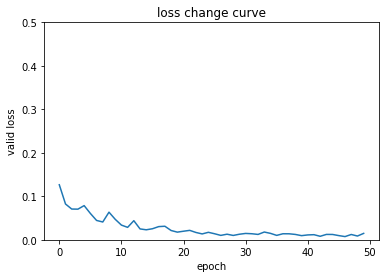

In [14]:
#main.py
FL = FocalLoss(class_num=class_num, gamma=2, average=False)

def cal_loss(pred, label, device):
    cnt_per_class = np.zeros(class_num)
    loss = FL(pred, label, device)

    loss = F.cross_entropy(pred, label, reduction='sum')
    pred = pred.max(1)[1]#得到最大值索引
    n_correct = pred.eq(label).sum().item()
    cnt_per_class = [cnt_per_class[j] + pred.eq(j).sum().item() for j in range(class_num)]
    return loss, n_correct, cnt_per_class


def cal_statistic(cm):
    total_pred = cm.sum(0)
    total_true = cm.sum(1)

    acc_SP = sum([cm[i, i] for i in range(1, class_num)]) / total_pred[1:class_num].sum()
    pre_i = [cm[i, i] / total_pred[i] for i in range(class_num)]
    rec_i = [cm[i, i] / total_true[i] for i in range(class_num)]
    F1_i = [2 * pre_i[i] * rec_i[i] / (pre_i[i] + rec_i[i]) for i in range(class_num)]

    pre_i = np.array(pre_i)
    rec_i = np.array(rec_i)
    F1_i = np.array(F1_i)
    pre_i[np.isnan(pre_i)] = 0
    rec_i[np.isnan(rec_i)] = 0
    F1_i[np.isnan(F1_i)] = 0

    return acc_SP, list(pre_i), list(rec_i), list(F1_i)


def train_epoch(train_loader, device, model, optimizer, total_num):
    all_labels = []
    all_res = []
    model.train()
    total_loss = 0
    total_correct = 0
    cnt_per_class = np.zeros(class_num)
    for batch in tqdm(train_loader, mininterval=0.5, desc='- (Training)  ', leave=False):
        sig, fea_plus, label, = map(lambda x: x.to(device), batch)
        # forward
        optimizer.zero_grad()
        pred = model(sig, fea_plus)
        all_labels.extend(label.cpu().numpy())
        all_res.extend(pred.max(1)[1].cpu().numpy())
        # backward
        loss, n_correct, cnt = cal_loss(pred, label, device)
        loss.backward()
        # update
        optimizer.step_and_update_lr()

        total_loss += loss.item()
        total_correct += n_correct
        cnt_per_class += cnt
    # cm = confusion_matrix(all_labels, all_res)
    # print(cm)
    # acc_SP, pre_i, rec_i, F1_i = cal_statistic(cm)
    # print('acc_SP is : {acc_SP}'.format(acc_SP=acc_SP))
    # print('pre_i is : {pre_i}'.format(pre_i=pre_i))
    # print('rec_i is : {rec_i}'.format(rec_i=rec_i))
    # print('F1_i is : {F1_i}'.format(F1_i=F1_i))
    train_loss = total_loss / total_num
    train_acc = total_correct / total_num
    return train_loss, train_acc, cnt_per_class


def eval_epoch(valid_loader, device, model, total_num):
    all_labels = []
    all_res = []
    model.eval()
    total_loss = 0
    total_correct = 0
    cnt_per_class = np.zeros(class_num)
    with torch.no_grad():
        for batch in tqdm(valid_loader, mininterval=0.5, desc='- (Validation)  ', leave=False):
            sig, fea_plus, label, = map(lambda x: x.to(device), batch)
            # forward
            pred = model(sig, fea_plus)  # emd.contiguous().view(len(label), fea_num, -1)
            all_labels.extend(label.cpu().numpy())
            all_res.extend(pred.max(1)[1].cpu().numpy())
            loss, n_correct, cnt = cal_loss(pred, label, device)

            total_loss += loss.item()
            total_correct += n_correct
            cnt_per_class += cnt
    cm = confusion_matrix(all_labels, all_res)
    print(cm)
    acc_SP, pre_i, rec_i, F1_i = cal_statistic(cm)
    print('acc_SP is : {acc_SP}'.format(acc_SP=acc_SP))
    print('pre_i is : {pre_i}'.format(pre_i=pre_i))
    print('rec_i is : {rec_i}'.format(rec_i=rec_i))
    print('F1_i is : {F1_i}'.format(F1_i=F1_i))
    valid_F1.append(F1_i)
    valid_loss = total_loss / total_num
    valid_acc = total_correct / total_num
    return valid_loss, valid_acc, cnt_per_class, sum(F1_i[1:3]）

#检测最好测试集效果
def eval_epoch_2(valid_loader, device, model, total_num):
    all_labels = []
    all_res = []
    model.eval()
    total_loss = 0
    total_correct = 0
    cnt_per_class = np.zeros(class_num)
    with torch.no_grad():
        for batch in tqdm(valid_loader, mininterval=0.5, desc='- (Validation)  ', leave=False):
            sig, fea_plus, label, = map(lambda x: x.to(device), batch)
            # forward
            pred = model(sig, fea_plus)  # emd.contiguous().view(len(label), fea_num, -1)
            all_labels.extend(label.cpu().numpy())
            all_res.extend(pred.max(1)[1].cpu().numpy())
            loss, n_correct, cnt = cal_loss(pred, label, device)

            total_loss += loss.item()
            total_correct += n_correct
            cnt_per_class += cnt
    cm = confusion_matrix(all_labels, all_res)
    print(cm)
    acc_SP, pre_i, rec_i, F1_i = cal_statistic(cm)
    print('acc_SP is : {acc_SP}'.format(acc_SP=acc_SP))
    print('pre_i is : {pre_i}'.format(pre_i=pre_i))
    print('rec_i is : {rec_i}'.format(rec_i=rec_i))
    print('F1_i is : {F1_i}'.format(F1_i=F1_i))
    test_F1.append(F1_i)
    valid_loss = total_loss / total_num
    valid_acc = total_correct / total_num
    return valid_loss, valid_acc, cnt_per_class, sum(F1_i[1:3])


def test_epoch(valid_loader, device, model, total_num):
    all_labels = []
    all_res = []
    all_pres = []
    all_recs = []
    all_pred = []
    model.eval()
    total_loss = 0
    total_correct = 0
    cnt_per_class = np.zeros(class_num)
    with torch.no_grad():
        for batch in tqdm(valid_loader, mininterval=0.5, desc='- (Validation)  ', leave=False):
            sig, fea_plus, label, = map(lambda x: x.to(device), batch)
            # forward
            pred = model(sig, fea_plus)  # emd.contiguous().view(len(label), fea_num, -1)
            all_labels.extend(label.cpu().numpy())
            all_res.extend(pred.max(1)[1].cpu().numpy())
            all_pred.extend(pred.cpu().numpy())
            loss, n_correct, cnt = cal_loss(pred, label, device)

            total_loss += loss.item()
            total_correct += n_correct
            cnt_per_class += cnt

    # np.savetxt('all_pres.txt',all_pres)
    # np.savetxt('all_recs.txt', all_recs)
    np.savetxt('all_pred.txt',all_pred)
    np.savetxt('all_label.txt', all_labels)
    all_pred = np.array(all_pred)
    plot_roc(all_labels,all_pred)
    cm = confusion_matrix(all_labels, all_res)
    print(cm)
    acc_SP, pre_i, rec_i, F1_i = cal_statistic(cm)
    print('acc_SP is : {acc_SP}'.format(acc_SP=acc_SP))
    print('pre_i is : {pre_i}'.format(pre_i=pre_i))
    print('rec_i is : {rec_i}'.format(rec_i=rec_i))
    print('F1_i is : {F1_i}'.format(F1_i=F1_i))
    test_acc = total_correct / total_num
    print('test_acc is : {test_acc}'.format(test_acc=test_acc))



#輸入數據開始訓練
model_name = 'beat_ecg_transform.chkpt'

# # #SMOTE平衡
# smo = SMOTE()
# a, b = smo.fit_resample(whole_data[:, 1:], whole_data[:, 0])
# whole_data = np.c_[b, a]


for r in range(1):#進行1次训练
    time_start_i = time.time()
                                                     
#     raw_train, raw_valid, _, _ = train_test_split(whole_data, list(whole_data[:, 0]), test_size=0.2,
#                                                       random_state=r,stratify=list(whole_data[:, 0]))
#     raw_valid, raw_test, _, _ = train_test_split(raw_valid, list(raw_valid[:, 0]), test_size=0.6666,
#                                              random_state=r,stratify=list(raw_valid[:, 0]))

    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')

# original模型
    model = Transformer(device=device, d_feature=SIG_LEN, d_model=d_model, d_inner=d_inner,
                        n_layers=num_layers, n_head=num_heads, d_k=64, d_v=64, dropout=dropout, class_num=class_num)
    model = model.to(device) 
    
    
# #pre-trained模型
#     model_name_0 = 'pre_train.chkpt'
#     test_model_name_0 = str(r) + model_name_0
#     model = Transformer(device=device, d_feature=SIG_LEN, d_model=d_model, d_inner=d_inner,
#                         n_layers=num_layers, n_head=num_heads, d_k=64, d_v=64, dropout=dropout,
#                         class_num=class_num)
#     chkpoint = torch.load(test_model_name_0, map_location='cuda:0')
#     model.load_state_dict(chkpoint['model'])
#     model = model.to(device)

    
    optimizer = ScheduledOptim(
        Adam(filter(lambda x: x.requires_grad, model.parameters()),
             betas=(0.9, 0.999), eps=1e-08), d_model, warm_steps)
    train_accs = []
    valid_accs = []
    eva_indis = []
    train_losses = []
    valid_losses = []
    valid_F1 = []
    test_F1 = []
    for epoch_i in range(epoch):
        print('[ Epoch', epoch_i, ']')
        raw_train, raw_valid, _, _ = train_test_split(whole_data, list(whole_data[:, 0]), test_size=0.2,
                                                      random_state=r,stratify=list(whole_data[:, 0]))
        train_data = SignalDataset(raw_train)
        valid_data = SignalDataset(raw_valid)
        test_data = SignalDataset_o(raw_test)

        train_loader = DataLoader(dataset=train_data,
                                  batch_size=batch_size,
                                  num_workers=2,
                                  shuffle=True)
        valid_loader = DataLoader(dataset=valid_data,
                                  batch_size=batch_size,
                                  num_workers=2,
                                  shuffle=True)
        test_loader = DataLoader(dataset=test_data,
                                 batch_size=batch_size,
                                 num_workers=2,
                                 shuffle=True)
#训练                                                     
        start = time.time()
        train_loss, train_acc, cnt = train_epoch(train_loader, device, model, optimizer, train_data.__len__())
        print('  - (Training)  loss: {loss: 8.5f}, accuracy: {accu:3.3f} %, '
              'elapse: {elapse:3.3f} min'.format(loss=train_loss, accu=100 * train_acc,
                                                 elapse=(time.time() - start) / 60))
        print(cnt)
        train_accs.append(train_acc)
        train_losses.append(train_loss)
                         
                                                     
#验证                                                     
        start = time.time()
        valid_loss, valid_acc, cnt, eva_indi = eval_epoch(valid_loader, device, model, valid_data.__len__())
        print('  - (Validation)  loss: {loss: 8.5f}, accuracy: {accu:3.3f} %, '
              'elapse: {elapse:3.3f} min'.format(loss=valid_loss, accu=100 * valid_acc,
                                                 elapse=(time.time() - start) / 60))
        print(cnt)
        valid_accs.append(valid_acc)
        eva_indis.append(eva_indi)
        valid_losses.append(valid_loss)
        
                                                     
                                                     
#保存最佳模型
        eva_indis.append(eva_indi)
        model_state_dict = model.state_dict()
        checkpoint = {
            'model': model_state_dict,
            'config_file': 'config',
            'epoch': epoch_i}

        if eva_indi >= max(eva_indis):
            torch.save(checkpoint, str(r)+model_name)
            print('    - [Info] The checkpoint file has been updated.')

    print('——ALL DONE!——')
    time_consume = (time.time() - time_start_i)
    print('total ' + str(time_consume) + 'seconds')
    plt.plot(valid_losses)
    plt.xlabel('epoch')
    plt.ylim([0.0, 0.5])
    plt.ylabel('valid loss')
    plt.title('loss change curve')
    plt.show()

In [79]:
# [100, 103, 105, 111, 113, 117, 121, 123, 200, 202, 210, 212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234]
with open('./test_data.txt', "rb") as text4:
    Test_ecg_data = pickle.load(text4)
with open('./test_label.txt', "rb") as text5:
    Test_label = pickle.load(text5)
with open('./test_RR.txt', "rb") as text6:
    RR_Test = pickle.load(text6)

print(Test_ecg_data.shape)
print(Test_label.shape)
print(RR_Test.shape)

#测试集
#测试添加扰动后鲁棒性
def data_robust(ecg):
    ecg_new = ecg + 0.01*np.random.randint(15,40)*np.sin(np.pi/np.random.randint(40,90)*np.arange(len(ecg[0]))+np.pi*np.random.randint(0,10)/10)
    ecg_new = ecg_new + np.random.normal(0,0.01*np.random.randint(0,10),len(ecg[0]))
    ecg_new = ecg_new + 0.02*np.random.randint(-20,21)
    return ecg_new

ecg_sig = Test_ecg_data[:,0,:]
ecg_sig_new=data_robust(ecg_sig)#测试集

pure_test = np.concatenate((Test_label,RR_Test,ecg_sig),axis=1)#滤波后测试集
pure_test_robust = np.concatenate((Test_label,RR_Test,ecg_sig_new),axis=1)#加入扰动后测试集
unpure_test = np.concatenate((Test_label,RR_Test,Test_ecg_data_raw),axis=1)#未滤波前测试集

# Train_label_zero=Test_label
# N_=0
# S_=0
# V_=0
# F_=0
# for i in range(len(Train_label_zero)):
#     if Train_label_zero[i]==0:
#         N_+=1        
#     if Train_label_zero[i]==1:
#         S_+=1
#     if Train_label_zero[i]==2:
#         V_+=1
#         print(i)
#     if Train_label_zero[i]==3:
#         F_+=1
    
# print(N_)
# print(S_)
# print(V_)
# print(F_)

(49552, 2, 256)
(49552, 1)
(49552, 2)
0
6
10
12
20
22
24
26
30
34
36
38
40
44
46
52
54
58
60
66
72
74
82
84
86
88
100
102
109
111
143
145
147
149
151
153
154
156
163
165
167
169
193
195
197
199
201
203
205
207
209
211
213
215
217
221
223
232
234
236
238
240
247
249
251
253
254
256
266
268
270
272
274
276
278
287
290
294
296
298
300
302
304
307
309
311
313
315
324
326
328
381
383
385
387
389
391
393
395
397
399
401
402
404
406
408
410
412
414
416
418
420
422
424
426
428
430
432
434
436
437
439
440
442
447
449
451
453
455
457
475
477
478
479
481
483
493
495
497
499
503
505
507
508
510
514
516
520
522
526
527
531
533
537
541
545
547
551
553
557
559
563
565
569
571
581
583
598
600
602
606
608
610
614
616
622
624
630
632
646
648
650
654
656
658
660
701
703
705
713
715
717
719
721
725
727
729
731
735
737
738
740
748
750
752
756
758
770
772
776
777
788
792
796
800
804
808
854
886
892
916
922
926
930
938
950
952
954
963
964
965
966
971
973
983
985
987
989
991
995
997
999
1001
1003
1007
1009
10

44707
44711
44713
44715
44717
44723
44727
44729
44731
44733
44739
44743
44747
44751
44755
44759
44763
44767
44771
44773
44774
44780
44784
44788
44794
44798
44802
44806
44810
44814
44818
44822
44826
44830
44834
44838
44842
44846
44850
44854
44858
44862
44866
44870
44876
44881
44883
44884
44886
44888
44891
44893
44897
44900
44901
44903
44907
44912
44916
44917
44919
44937
44940
44946
44952
44958
44965
44967
44973
44977
44981
44985
44989
44993
44997
45001
45005
45009
45013
45017
45021
45025
45028
45029
45031
45037
45041
45045
45049
45053
45057
45061
45062
45066
45070
45074
45078
45082
45089
45093
45097
45101
45103
45107
45111
45112
45118
45124
45128
45132
45136
45140
45144
45148
45149
45155
45157
45158
45162
45166
45168
45172
45176
45180
45184
45188
45189
45190
45192
45198
45204
45208
45212
45216
45220
45224
45227
45233
45240
45241
45243
45247
45248
45254
45256
45257
45259
45261
45263
45265
45269
45279
45280
45282
45284
45287
45289
45295
45299
45303
45307
45310
45322
45325
45327
45330
4533

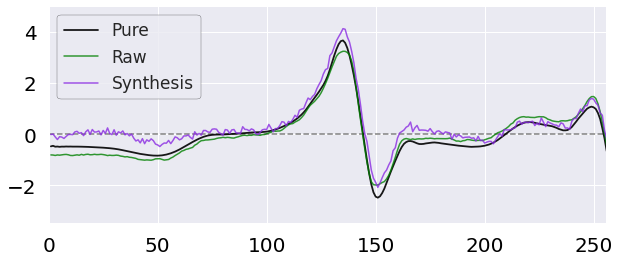

In [80]:
#三种类型测试集可视化
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 2

# s-39939 v-46230
beat_idx=46484
# ecg_sig_new=data_robust(ecg_sig)
x = np.arange(1, 257)
fig, ax = plt.subplots(figsize=(10,4))
yminorLocator = MultipleLocator(1)  # 将此y轴次刻度标签设置为0.1的倍数
xminorLocator = MultipleLocator(50)
ax.yaxis.set_minor_locator(yminorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
# ax.tick_params(which='major', length=5, width=1, direction='in', right='on', top='on',colors='black')
# ax.tick_params(which='minor', length=2.5, width=0.5,direction='in', right='on', top='on',colors='black')
ax.tick_params(which='major', length=5, width=0,colors='black')
ax.tick_params(which='minor', length=2.5, width=0,colors='black')
plt.axhline(y=0, ls="--", lw=1.5, color="gray")

#测试集
ax.plot(x, ecg_sig[beat_idx],color='black',alpha=0.9,lw=1.8,label='Pure')
ax.plot(x, Test_ecg_data_raw[beat_idx],color='green',alpha=0.8,lw=1.5,label='Raw')
ax.plot(x, ecg_sig_new[beat_idx],color='Blueviolet',alpha=0.8,lw=1.5,label='Synthesis')
# ax.plot(x, y1, color='Blueviolet')
ax.set_xlim([0, 256])
ax.set_ylim([-3.5, 5])
# ax.set_xlim([0, 3000])
# plt.grid(which='both', color='gray', ls='--')
# ax.patch.set_facecolor('gray')
# ax.plot(x, y1, color='red', alpha=0.6)
plt.tick_params(labelsize=20)
plt.legend(frameon=True,edgecolor='black',fontsize='17')
# plt.savefig("robust_beat_V.jpg", dpi=500)
plt.show()
# plt.plot(ecg_sig[beat_idx])
# plt.plot(ecg_sig_new[beat_idx])

未添加噪声


/tmp/ipykernel_2783/722392932.py:28: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


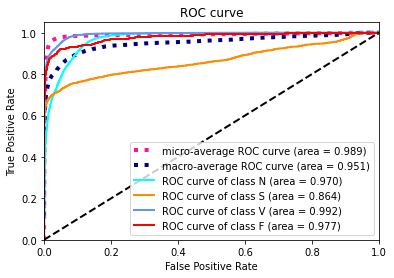

[[41208   143   188   261]
 [  692  1487   157     1]
 [  412    43  4262    87]
 [   77     0    29   505]]
acc_SP is : 0.8730978640234539
pre_i is : [0.9721389983250371, 0.8888224745965332, 0.9193270060396894, 0.5913348946135831]
rec_i is : [0.9858373205741627, 0.636285836542576, 0.8871773522064946, 0.8265139116202946]
F1_i is : [0.9789402415992587, 0.7416458852867831, 0.9029661016949152, 0.689419795221843]
test_acc is : 0.9578220858895705
elapse: 0.266 min


In [13]:
#利用最佳模型对三种测试集分别验证
class_num=4
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
FL = FocalLoss(class_num=class_num, gamma=2, average=False)

def cal_loss(pred, label, device):
    cnt_per_class = np.zeros(class_num)
    loss = FL(pred, label, device)

    loss = F.cross_entropy(pred, label, reduction='sum')
    pred = pred.max(1)[1]#得到最大值索引
    n_correct = pred.eq(label).sum().item()
    cnt_per_class = [cnt_per_class[j] + pred.eq(j).sum().item() for j in range(class_num)]
    return loss, n_correct, cnt_per_class


def cal_statistic(cm):
    total_pred = cm.sum(0)
    total_true = cm.sum(1)
    # total_true = np.array([17703,   491,  1357,   159])
    # special acc, abnormal inlcuded only
    acc_SP = sum([cm[i, i] for i in range(1, class_num)]) / total_pred[1:class_num].sum()
    pre_i = [cm[i, i] / total_pred[i] for i in range(class_num)]
    rec_i = [cm[i, i] / total_true[i] for i in range(class_num)]
    F1_i = [2 * pre_i[i] * rec_i[i] / (pre_i[i] + rec_i[i]) for i in range(class_num)]

    pre_i = np.array(pre_i)
    rec_i = np.array(rec_i)
    F1_i = np.array(F1_i)
    pre_i[np.isnan(pre_i)] = 0
    rec_i[np.isnan(rec_i)] = 0
    F1_i[np.isnan(F1_i)] = 0

    return acc_SP, list(pre_i), list(rec_i), list(F1_i)
r=0
def test_epoch(valid_loader, device, model, total_num):
    all_labels = []
    all_res = []
    all_pres = []
    all_recs = []
    all_pred = []
    model.eval()
    total_loss = 0
    total_correct = 0
    cnt_per_class = np.zeros(class_num)
    with torch.no_grad():
        for batch in tqdm(valid_loader, mininterval=0.5, desc='- (Validation)  ', leave=False):
            sig, fea_plus, label, = map(lambda x: x.to(device), batch)
            # forward
            pred = model(sig, fea_plus)  # emd.contiguous().view(len(label), fea_num, -1)
            all_labels.extend(label.cpu().numpy())
            all_res.extend(pred.max(1)[1].cpu().numpy())
            all_pred.extend(pred.cpu().numpy())
            loss, n_correct, cnt = cal_loss(pred, label, device)

            total_loss += loss.item()
            total_correct += n_correct
            cnt_per_class += cnt

    # np.savetxt('all_pres.txt',all_pres)
    # np.savetxt('all_recs.txt', all_recs)
    np.savetxt('all_pred.txt',all_pred)
    np.savetxt('all_label.txt', all_labels)
    all_pred = np.array(all_pred)
    plot_roc(all_labels,all_pred)
    cm = confusion_matrix(all_labels, all_res)
    print(cm)
    acc_SP, pre_i, rec_i, F1_i = cal_statistic(cm)
    print('acc_SP is : {acc_SP}'.format(acc_SP=acc_SP))
    print('pre_i is : {pre_i}'.format(pre_i=pre_i))
    print('rec_i is : {rec_i}'.format(rec_i=rec_i))
    print('F1_i is : {F1_i}'.format(F1_i=F1_i))
    test_acc = total_correct / total_num
    print('test_acc is : {test_acc}'.format(test_acc=test_acc))
    
# a, b = SMOTE().fit_resample(whole_data[:, 1:], whole_data[:, 0])
# whole_data = np.c_[b, a]
raw_train, raw_valid, _, _ = train_test_split(whole_data, list(whole_data[:, 0]), test_size=0.3,
                                                  random_state=r,stratify=list(whole_data[:, 0]))
# raw_valid, raw_test, _, _ = train_test_split(raw_valid, list(raw_valid[:, 0]), test_size=0.6666,
#                                          random_state=r,stratify=list(raw_valid[:, 0]))

#测试扰动后性能
model_name = 'beat_ecg_transform.chkpt'
test_data = SignalDataset_o(pure_test)#这里更改测试集类型
test_loader = DataLoader(dataset=test_data,
                         batch_size=batch_size,
                         num_workers=2,
                         shuffle=True)
test_model_name = str(r) + model_name
model = Transformer(device=device, d_feature=test_data.sig_len, d_model=d_model, d_inner=d_inner,
                    n_layers=num_layers, n_head=num_heads, d_k=64, d_v=64, dropout=dropout,
                    class_num=class_num)
chkpoint = torch.load(test_model_name, map_location='cuda:0')
model.load_state_dict(chkpoint['model'])
model = model.to(device)

start = time.time()
test_epoch(test_loader, device, model, test_data.__len__())
print('elapse: {elapse:3.3f} min'.format(elapse=(time.time() - start) / 60))